In [1]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt
from tqdm.autonotebook import tqdm
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [2]:
train_frame = pd.read_pickle("../../data/train_data.pkl")
test_frame = pd.read_pickle("../../data/test_data.pkl")
#train_frame = train_frame.iloc[-1:]; test_frame = train_frame;

In [3]:
class TraceDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        input = torch.tensor(train_frame.iloc[idx]['input'], dtype=torch.float32)
        target = torch.tensor(train_frame.iloc[idx]['target'], dtype=torch.float32)
        return input, target

train_dataset = TraceDataset(train_frame)
test_dataset = TraceDataset(test_frame)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [4]:
def bicycle_model_eval(input, last_pose):
    # This version takes in an input of dim 5
    states = []  # torch.zeros((81, 4))
    L = 0.3302
    TS = 0.1
    X, Y, THETA, V = 0, 1, 2, 3
    #states.append(torch.tensor([last_pose[0],last_pose[1],last_pose[2],input[0]], requires_grad=True))
    state = torch.zeros((4,))
    state[X] = last_pose[0]
    state[Y] = last_pose[1]
    state[THETA] = last_pose[2]
    state[V] = input[0]
    states.append(state)
    for i in range(1,81):
        # Advance bicycle model
        state = torch.zeros((4,))
        state[X] = states[i-1][X] + (TS * states[i-1][V] * torch.cos(states[i-1][THETA]))
        state[Y] = states[i-1][Y] + (TS * states[i-1][V] * torch.sin(states[i-1][THETA]))
        state[THETA] = states[i-1][THETA] + (TS * (states[i-1][V] * torch.tan(input[1])) / L)
        state[V] = states[i-1][V] + TS*input[2]
        states.append(state)
        #states.append(
        #    torch.tensor(
        #        [states[i-1][X] + (TS * states[i-1][V] * torch.cos(states[i-1][THETA])),
        #         states[i-1][Y] + (TS * states[i-1][V] * torch.sin(states[i-1][THETA])),
        #         states[i-1][THETA] + (TS * (states[i-1][V] * torch.tan(input[1])) / L),
        #         states[i-1][V] + TS*input[2]], requires_grad=True))
        #states[i, dX] = states[i-1,V] * torch.cos(trace[i-1,THETA])
        #states[i, dY] = states[i-1,V] * torch.sin(trace[i-1,THETA])
        #states[i, dTHETA] = (states[i-1,V] * torch.tan(input[4])) / L
        #states[i, dV] = input[5]
        #states[i, V] = states[i-1, V] + TS*states[i, dV]
    trace = torch.vstack(states)[1:,0:3]
    return trace


def custom_loss_func(prediction, target, output):
    loss = F.mse_loss(prediction, target)
    #loss += 10*output[0]**2 if output[0]<0 else 0
    #loss += 2*torch.linalg.norm(output)**2
    return loss

class LSTMPredictor(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=10, target_size=3):
        super(LSTMPredictor, self).__init__()
        self.hidden_dim = hidden_dim

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2output = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Linear(hidden_dim, target_size)
        )

    def forward(self, inputs):
        lstm_out, _ = self.lstm(inputs)
        output = self.hidden2output(lstm_out)
        output = torch.column_stack([F.softplus(output[:,0]), torch.tanh(output[:,1])*np.pi, output[:,2]])
        return output
    
    def predict(self, inputs, horizon=80):
        pass

In [5]:
net = LSTMPredictor()
net.load_state_dict(torch.load("best_simple_bicycle.pt"))

<All keys matched successfully>

In [6]:
torch.tensor(train_frame.iloc[0]['input'])

tensor([[-58.9267,  31.1195,   2.0114],
        [-59.0875,  31.4569,   2.0265],
        [-59.2471,  31.7847,   2.0320],
        [-59.4060,  32.1001,   2.0484],
        [-59.5651,  32.4038,   2.0645],
        [-59.7262,  32.6999,   2.0798],
        [-59.8943,  32.9917,   2.1144],
        [-60.0724,  33.2777,   2.1533],
        [-60.2605,  33.5560,   2.1888],
        [-60.4569,  33.8287,   2.2108]], dtype=torch.float64)

In [7]:
inp = torch.tensor(train_frame.iloc[0]['input'], dtype=torch.float32)
outp = net(inp)
target = torch.tensor(train_frame.iloc[0]['target'], dtype=torch.float32)
outp.shape

torch.Size([10, 3])

In [8]:
outp_trace = bicycle_model_eval(outp[-1], inp[-1])
from viz_net import make_dot

In [9]:
loss = custom_loss_func(outp_trace, target.squeeze(), outp[-1])
#g = make_dot(loss)
#g.view()

In [10]:
#g = make_dot(outp[-1])
#g.view()

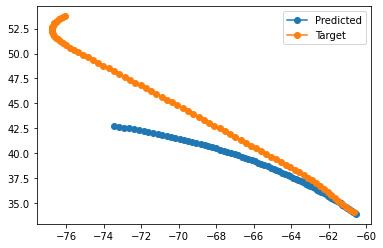

In [11]:
plt.plot(outp_trace[:,0].detach().numpy(), outp_trace[:,1].detach().numpy(), marker='o', label='Predicted')
plt.plot(target[:,0].detach().numpy(), target[:,1].detach().numpy(), marker='o', label='Target')
plt.legend()

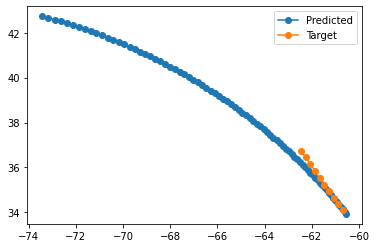

In [12]:
plt.plot(outp_trace[:,0].detach().numpy(), outp_trace[:,1].detach().numpy(), marker='o', label='Predicted')
plt.plot(target[:10,0].detach().numpy(), target[:10,1].detach().numpy(), marker='o', label='Target')
plt.legend()

In [13]:
loss = nn.MSELoss()
loss(outp_trace,torch.tensor(train_frame.iloc[0]['target'], dtype=torch.float32))

tensor(25.7573, grad_fn=<MseLossBackward0>)

  0%|          | 0/470 [00:00<?, ?it/s]

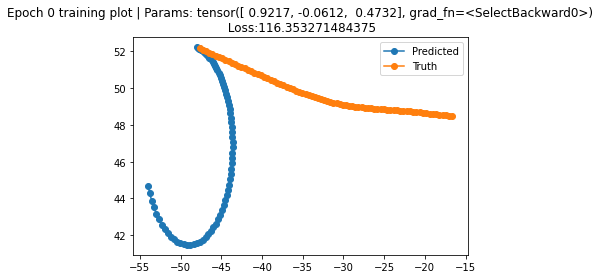

49.419003800128365


  0%|          | 0/118 [00:00<?, ?it/s]

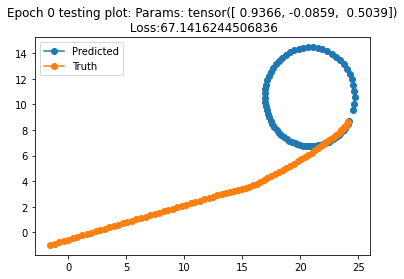

71.87889398154566
Epoch 0 | Train Loss: 49.419003800128365 | Test Loss: 71.87889398154566


  0%|          | 0/470 [00:00<?, ?it/s]

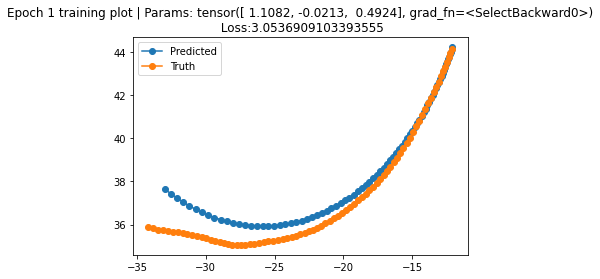

30.196268238158936


  0%|          | 0/118 [00:00<?, ?it/s]

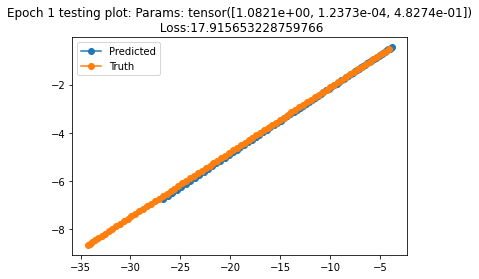

21.067317394886988
Epoch 1 | Train Loss: 30.196268238158936 | Test Loss: 21.067317394886988


  0%|          | 0/470 [00:00<?, ?it/s]

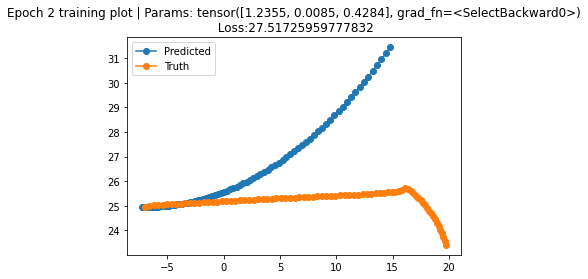

25.474752384804663


  0%|          | 0/118 [00:00<?, ?it/s]

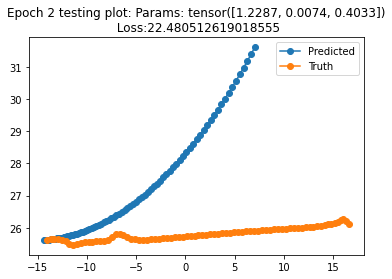

23.397002731339406
Epoch 2 | Train Loss: 25.474752384804663 | Test Loss: 23.397002731339406


  0%|          | 0/470 [00:00<?, ?it/s]

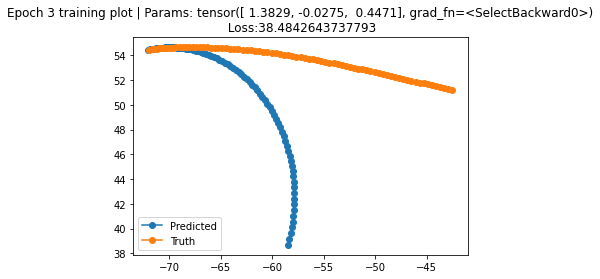

24.038443367785597


  0%|          | 0/118 [00:00<?, ?it/s]

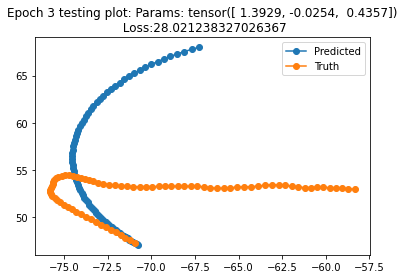

19.9023385664164
Epoch 3 | Train Loss: 24.038443367785597 | Test Loss: 19.9023385664164


  0%|          | 0/470 [00:00<?, ?it/s]

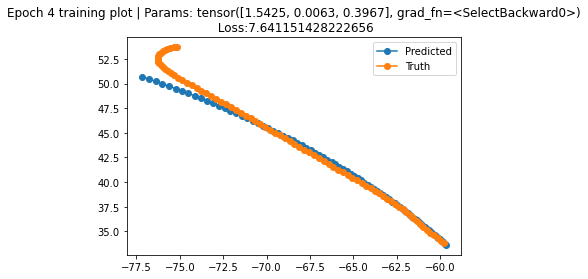

20.85225860387721


  0%|          | 0/118 [00:00<?, ?it/s]

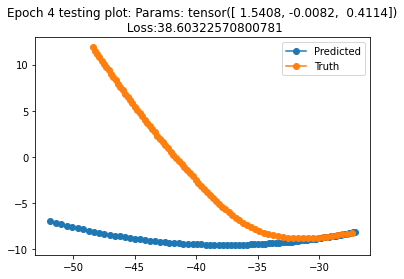

17.87692538762497
Epoch 4 | Train Loss: 20.85225860387721 | Test Loss: 17.87692538762497


  0%|          | 0/470 [00:00<?, ?it/s]

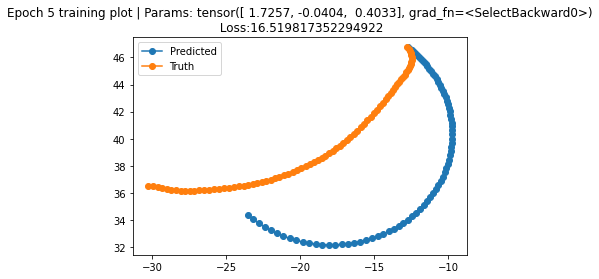

20.462778606059704


  0%|          | 0/118 [00:00<?, ?it/s]

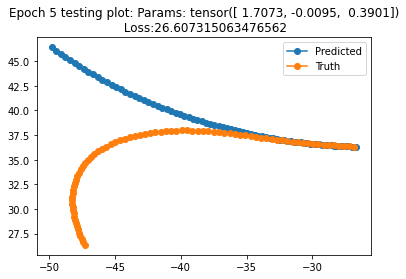

22.885482500165196
Epoch 5 | Train Loss: 20.462778606059704 | Test Loss: 22.885482500165196


  0%|          | 0/470 [00:00<?, ?it/s]

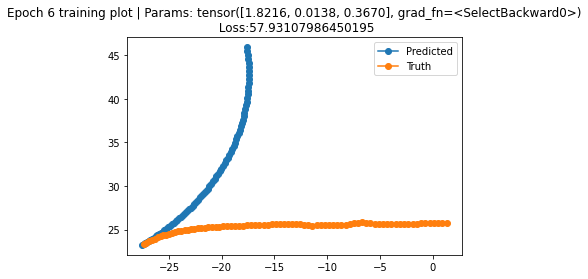

19.389279147919186


  0%|          | 0/118 [00:00<?, ?it/s]

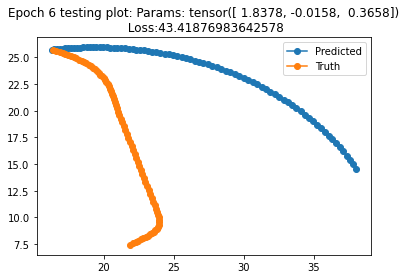

16.61246143306716
Epoch 6 | Train Loss: 19.389279147919186 | Test Loss: 16.61246143306716


  0%|          | 0/470 [00:00<?, ?it/s]

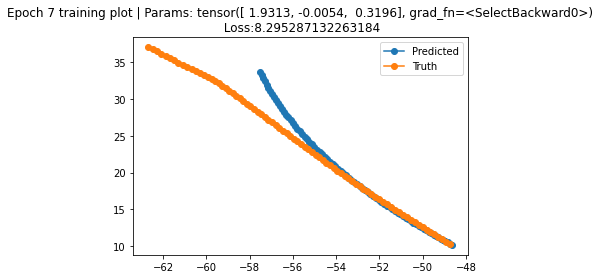

19.099534333259502


  0%|          | 0/118 [00:00<?, ?it/s]

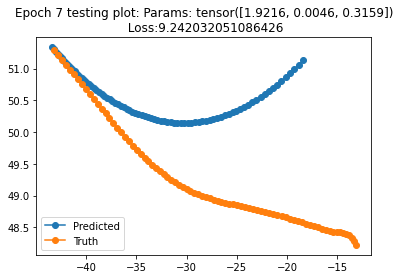

14.875133697259225
Epoch 7 | Train Loss: 19.099534333259502 | Test Loss: 14.875133697259225


  0%|          | 0/470 [00:00<?, ?it/s]

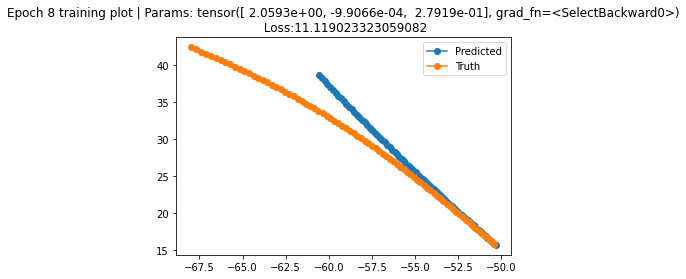

17.88619826106315


  0%|          | 0/118 [00:00<?, ?it/s]

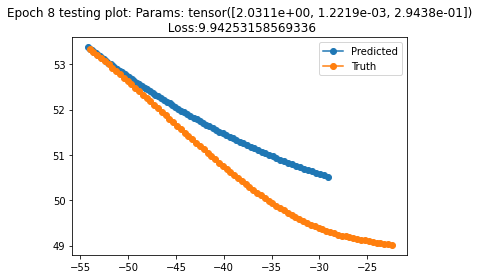

14.46926773099576
Epoch 8 | Train Loss: 17.88619826106315 | Test Loss: 14.46926773099576


  0%|          | 0/470 [00:00<?, ?it/s]

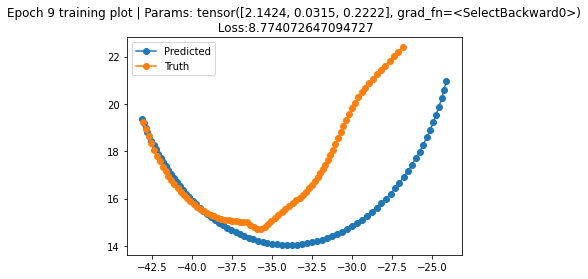

18.191647438039173


  0%|          | 0/118 [00:00<?, ?it/s]

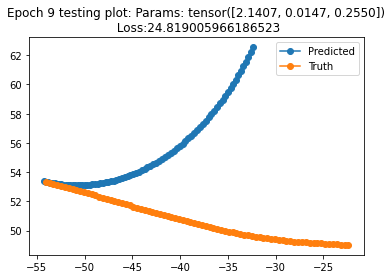

15.547814352532564
Epoch 9 | Train Loss: 18.191647438039173 | Test Loss: 15.547814352532564


  0%|          | 0/470 [00:00<?, ?it/s]

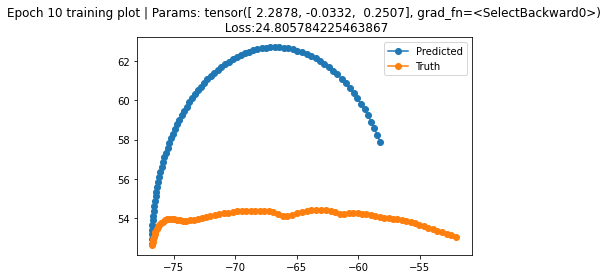

17.699850949201178


  0%|          | 0/118 [00:00<?, ?it/s]

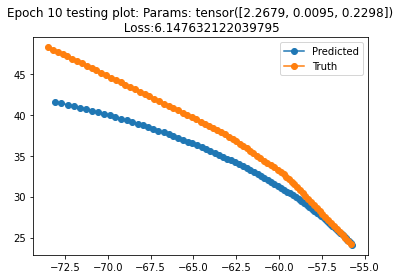

13.719433283401749
Epoch 10 | Train Loss: 17.699850949201178 | Test Loss: 13.719433283401749


  0%|          | 0/470 [00:00<?, ?it/s]

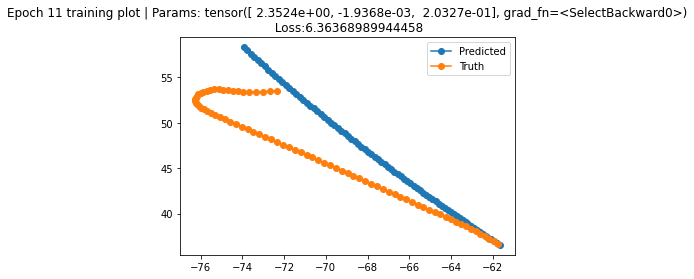

16.584912060803557


  0%|          | 0/118 [00:00<?, ?it/s]

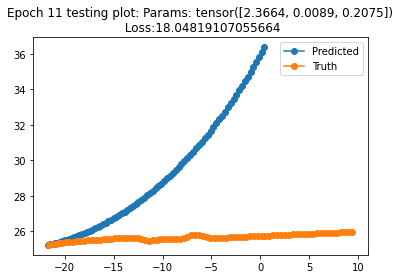

17.421790329076476
Epoch 11 | Train Loss: 16.584912060803557 | Test Loss: 17.421790329076476


  0%|          | 0/470 [00:00<?, ?it/s]

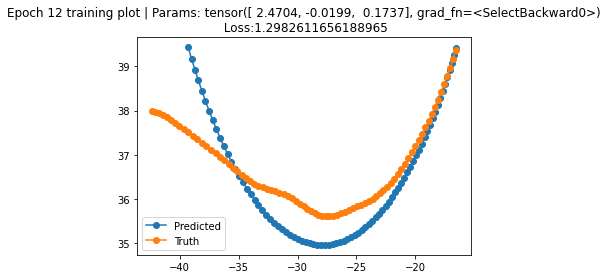

15.131190486410832


  0%|          | 0/118 [00:00<?, ?it/s]

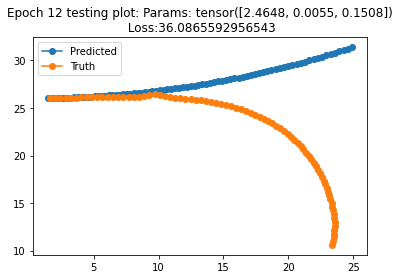

18.245424332255023
Epoch 12 | Train Loss: 15.131190486410832 | Test Loss: 18.245424332255023


  0%|          | 0/470 [00:00<?, ?it/s]

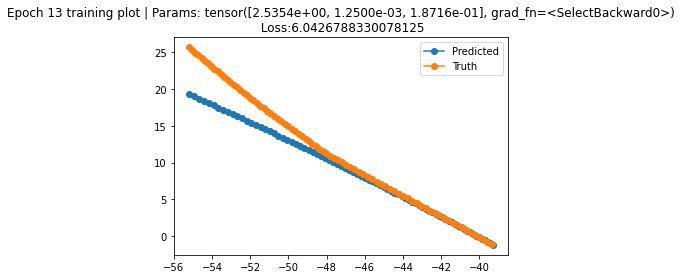

16.28497862638311


  0%|          | 0/118 [00:00<?, ?it/s]

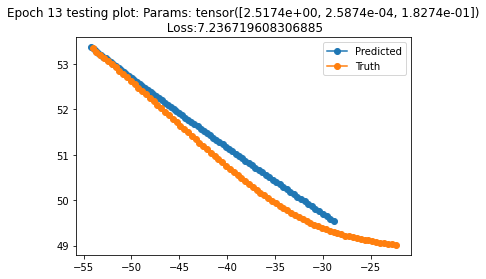

12.159068712743663
Epoch 13 | Train Loss: 16.28497862638311 | Test Loss: 12.159068712743663


  0%|          | 0/470 [00:00<?, ?it/s]

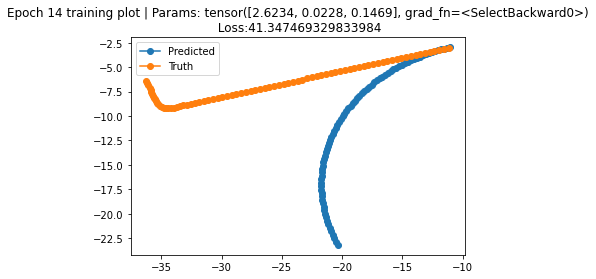

17.727456554199787


  0%|          | 0/118 [00:00<?, ?it/s]

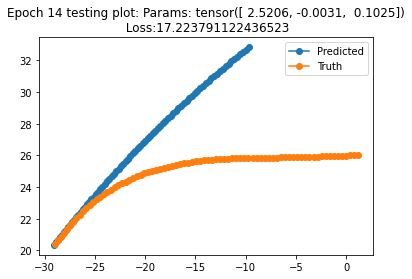

23.76862398749691
Epoch 14 | Train Loss: 17.727456554199787 | Test Loss: 23.76862398749691


  0%|          | 0/470 [00:00<?, ?it/s]

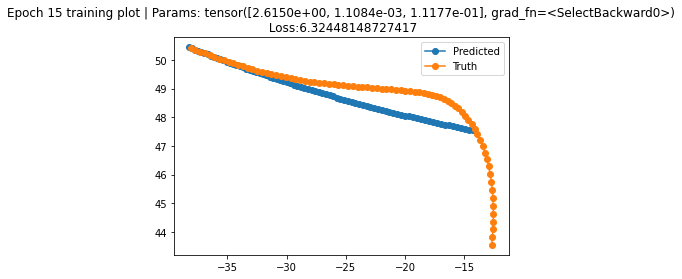

16.421232814484455


  0%|          | 0/118 [00:00<?, ?it/s]

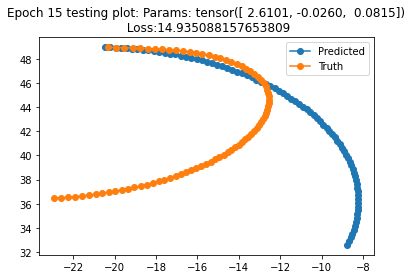

17.691404217380587
Epoch 15 | Train Loss: 16.421232814484455 | Test Loss: 17.691404217380587


  0%|          | 0/470 [00:00<?, ?it/s]

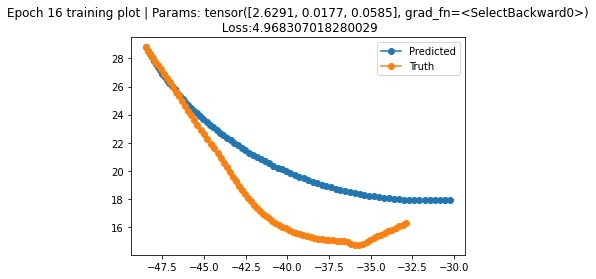

14.806426049166538


  0%|          | 0/118 [00:00<?, ?it/s]

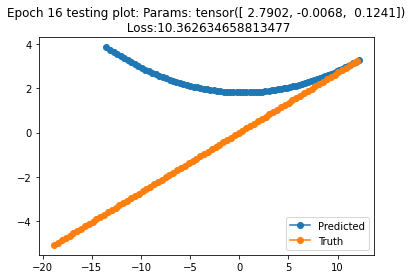

12.201480702323428
Epoch 16 | Train Loss: 14.806426049166538 | Test Loss: 12.201480702323428


  0%|          | 0/470 [00:00<?, ?it/s]

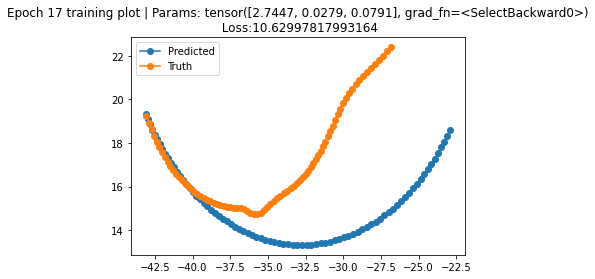

13.971090571170157


  0%|          | 0/118 [00:00<?, ?it/s]

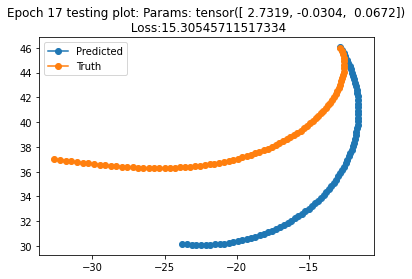

15.365822553634644
Epoch 17 | Train Loss: 13.971090571170157 | Test Loss: 15.365822553634644


  0%|          | 0/470 [00:00<?, ?it/s]

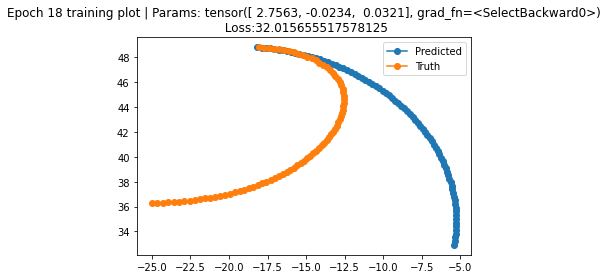

14.604435710450437


  0%|          | 0/118 [00:00<?, ?it/s]

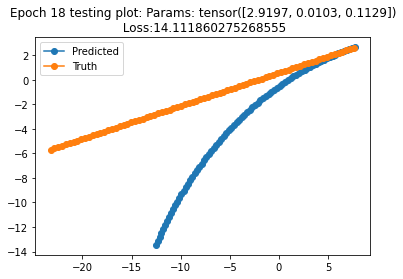

20.078693072169514
Epoch 18 | Train Loss: 14.604435710450437 | Test Loss: 20.078693072169514


  0%|          | 0/470 [00:00<?, ?it/s]

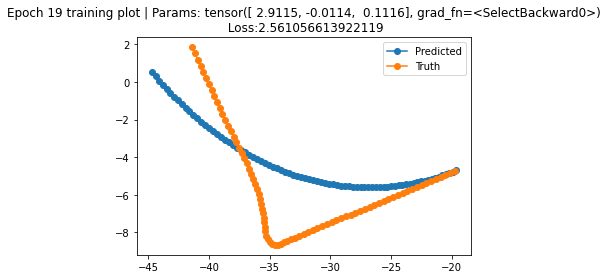

13.797768298362163


  0%|          | 0/118 [00:00<?, ?it/s]

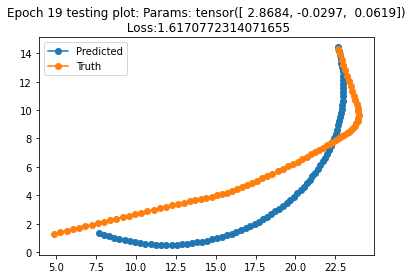

10.721403353295084
Epoch 19 | Train Loss: 13.797768298362163 | Test Loss: 10.721403353295084


  0%|          | 0/470 [00:00<?, ?it/s]

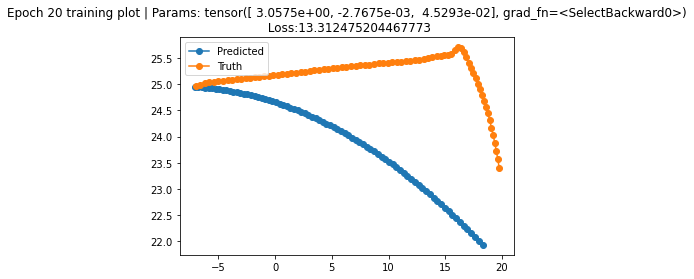

13.820399441237145


  0%|          | 0/118 [00:00<?, ?it/s]

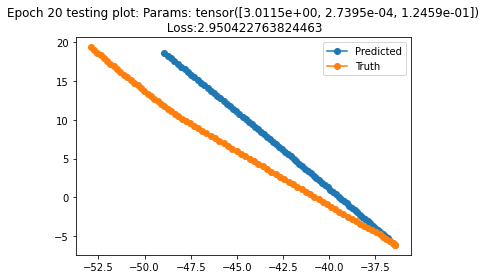

10.395071013499114
Epoch 20 | Train Loss: 13.820399441237145 | Test Loss: 10.395071013499114


  0%|          | 0/470 [00:00<?, ?it/s]

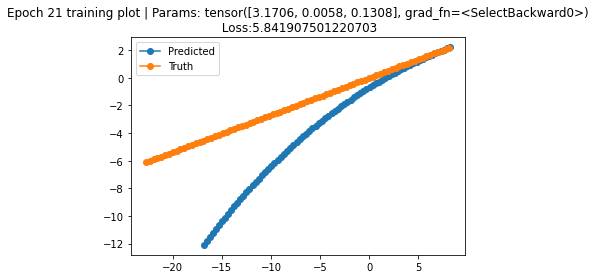

12.59735820813382


  0%|          | 0/118 [00:00<?, ?it/s]

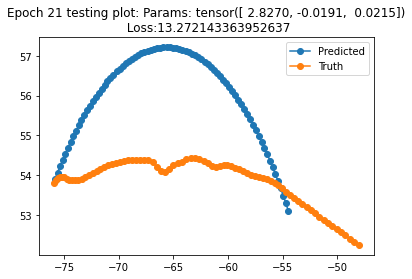

13.299031897116516
Epoch 21 | Train Loss: 12.59735820813382 | Test Loss: 13.299031897116516


  0%|          | 0/470 [00:00<?, ?it/s]

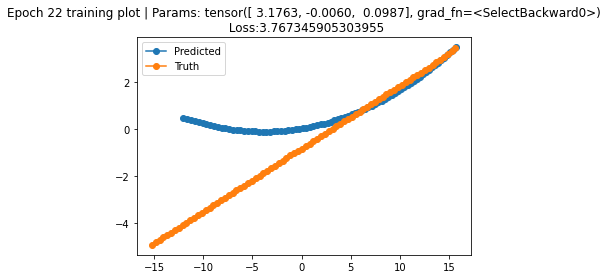

12.967179109187837


  0%|          | 0/118 [00:00<?, ?it/s]

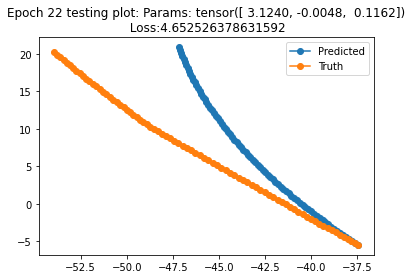

10.156727746886721
Epoch 22 | Train Loss: 12.967179109187837 | Test Loss: 10.156727746886721


  0%|          | 0/470 [00:00<?, ?it/s]

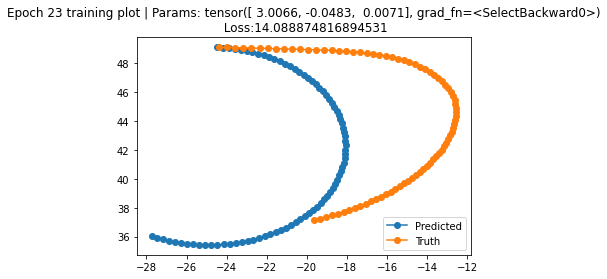

12.9253601496524


  0%|          | 0/118 [00:00<?, ?it/s]

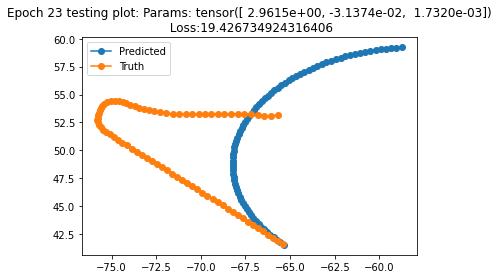

16.89580528412835
Epoch 23 | Train Loss: 12.9253601496524 | Test Loss: 16.89580528412835


  0%|          | 0/470 [00:00<?, ?it/s]

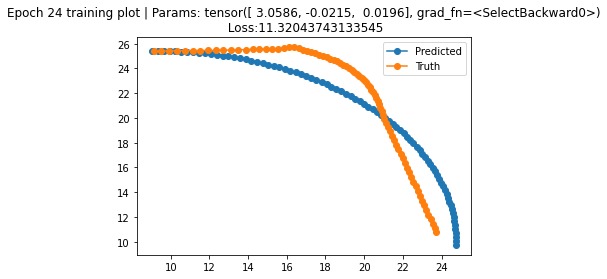

12.148453678729686


  0%|          | 0/118 [00:00<?, ?it/s]

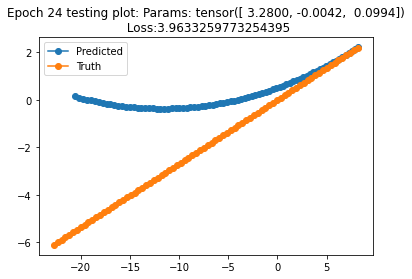

9.853417847116114
Epoch 24 | Train Loss: 12.148453678729686 | Test Loss: 9.853417847116114


  0%|          | 0/470 [00:00<?, ?it/s]

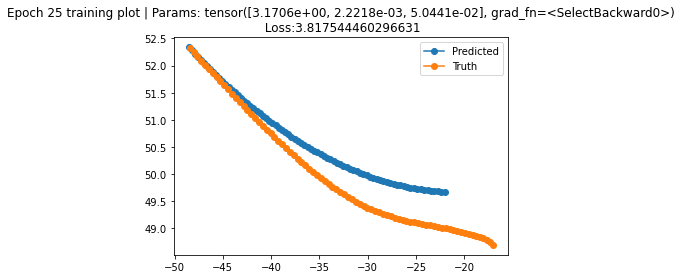

12.800043031636704


  0%|          | 0/118 [00:00<?, ?it/s]

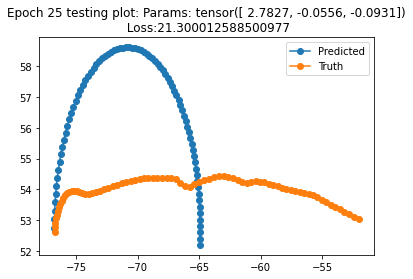

9.38803742093555
Epoch 25 | Train Loss: 12.800043031636704 | Test Loss: 9.38803742093555


  0%|          | 0/470 [00:00<?, ?it/s]

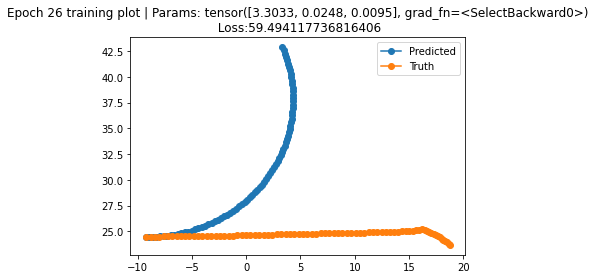

11.891312510028799


  0%|          | 0/118 [00:00<?, ?it/s]

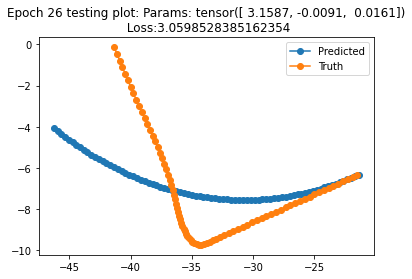

10.567469226101698
Epoch 26 | Train Loss: 11.891312510028799 | Test Loss: 10.567469226101698


  0%|          | 0/470 [00:00<?, ?it/s]

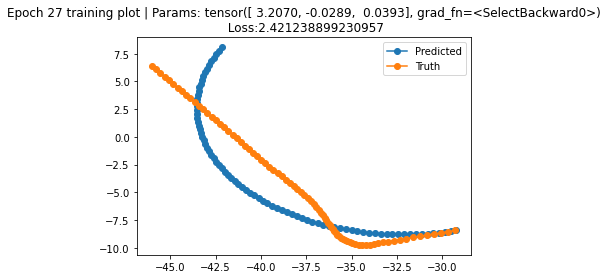

12.318060803096346


  0%|          | 0/118 [00:00<?, ?it/s]

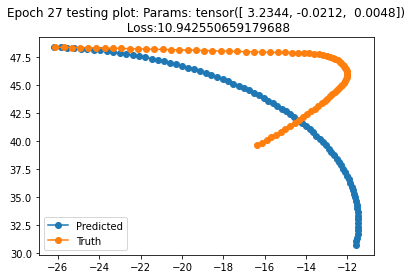

10.143322244033975
Epoch 27 | Train Loss: 12.318060803096346 | Test Loss: 10.143322244033975


  0%|          | 0/470 [00:00<?, ?it/s]

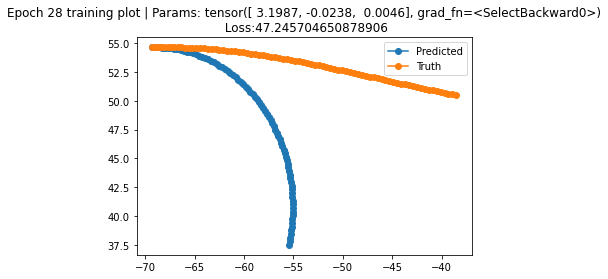

11.81894777404501


  0%|          | 0/118 [00:00<?, ?it/s]

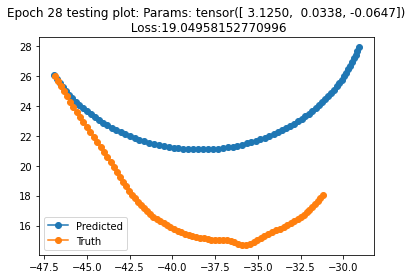

14.85450145198127
Epoch 28 | Train Loss: 11.81894777404501 | Test Loss: 14.85450145198127


  0%|          | 0/470 [00:00<?, ?it/s]

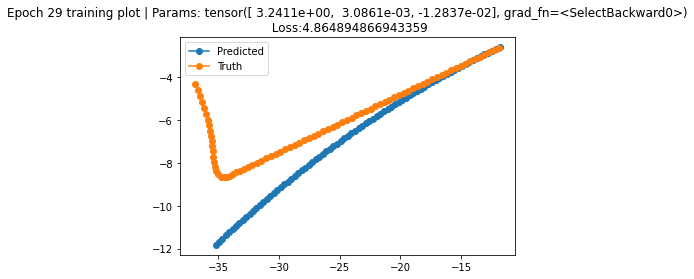

12.957259144554747


  0%|          | 0/118 [00:00<?, ?it/s]

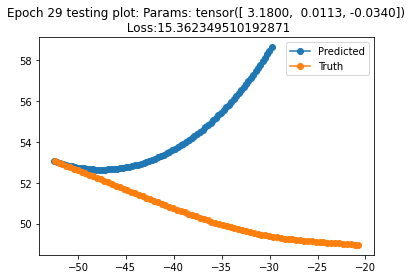

11.973377638449103
Epoch 29 | Train Loss: 12.957259144554747 | Test Loss: 11.973377638449103


  0%|          | 0/470 [00:00<?, ?it/s]

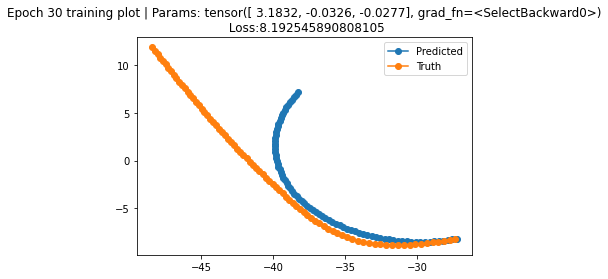

12.931385355934184


  0%|          | 0/118 [00:00<?, ?it/s]

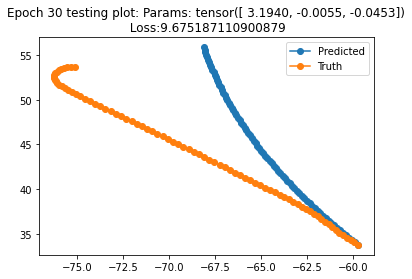

14.441872719991006
Epoch 30 | Train Loss: 12.931385355934184 | Test Loss: 14.441872719991006


  0%|          | 0/470 [00:00<?, ?it/s]

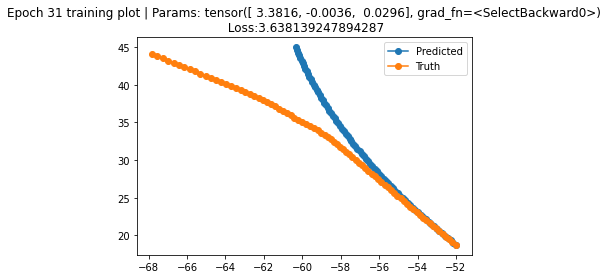

11.110179565878624


  0%|          | 0/118 [00:00<?, ?it/s]

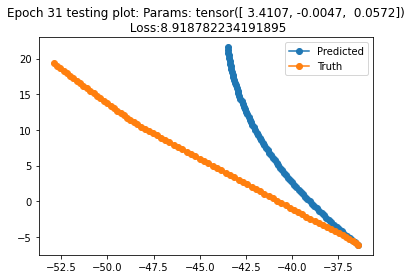

8.407849615913326
Epoch 31 | Train Loss: 11.110179565878624 | Test Loss: 8.407849615913326


  0%|          | 0/470 [00:00<?, ?it/s]

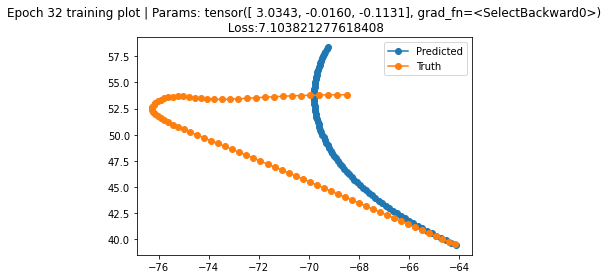

12.057795125626503


  0%|          | 0/118 [00:00<?, ?it/s]

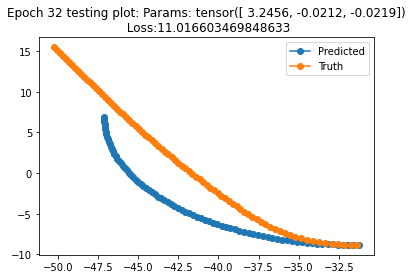

9.364829143225137
Epoch 32 | Train Loss: 12.057795125626503 | Test Loss: 9.364829143225137


  0%|          | 0/470 [00:00<?, ?it/s]

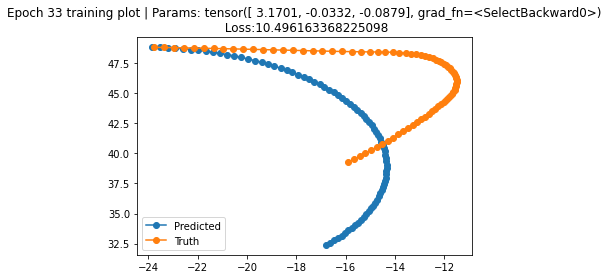

11.085549563613343


  0%|          | 0/118 [00:00<?, ?it/s]

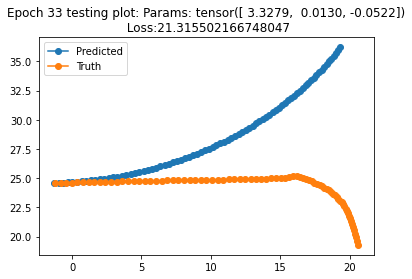

18.75487696518332
Epoch 33 | Train Loss: 11.085549563613343 | Test Loss: 18.75487696518332


  0%|          | 0/470 [00:00<?, ?it/s]

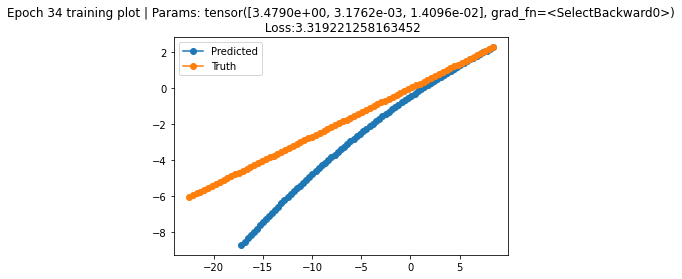

10.758540794570395


  0%|          | 0/118 [00:00<?, ?it/s]

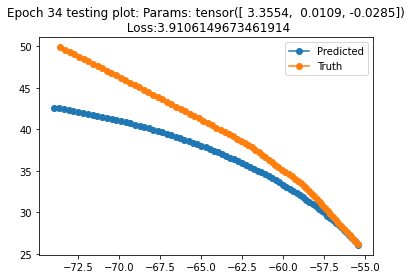

8.797853805756164
Epoch 34 | Train Loss: 10.758540794570395 | Test Loss: 8.797853805756164


  0%|          | 0/470 [00:00<?, ?it/s]

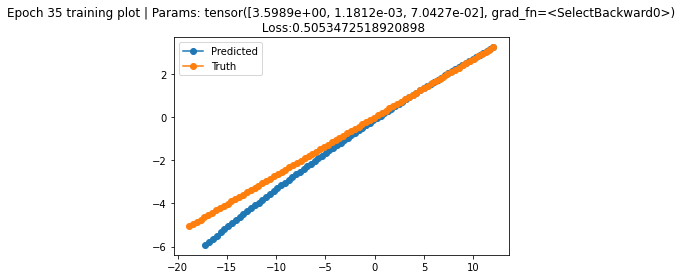

10.71815789690677


  0%|          | 0/118 [00:00<?, ?it/s]

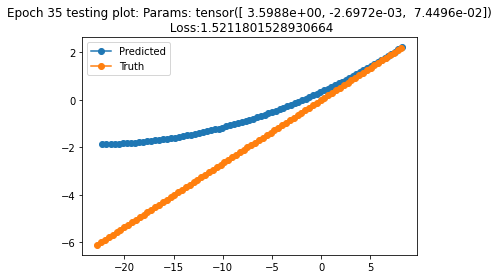

8.770423264069072
Epoch 35 | Train Loss: 10.71815789690677 | Test Loss: 8.770423264069072


  0%|          | 0/470 [00:00<?, ?it/s]

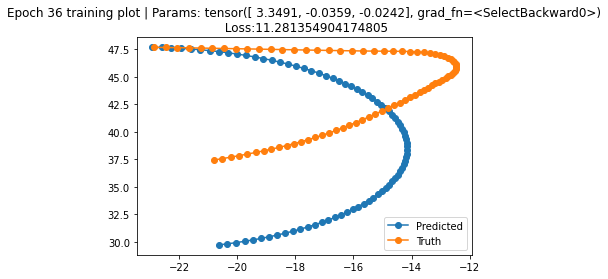

10.140442370987953


  0%|          | 0/118 [00:00<?, ?it/s]

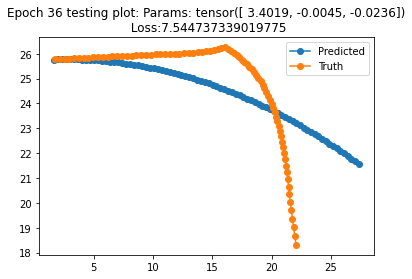

9.138326831161976
Epoch 36 | Train Loss: 10.140442370987953 | Test Loss: 9.138326831161976


  0%|          | 0/470 [00:00<?, ?it/s]

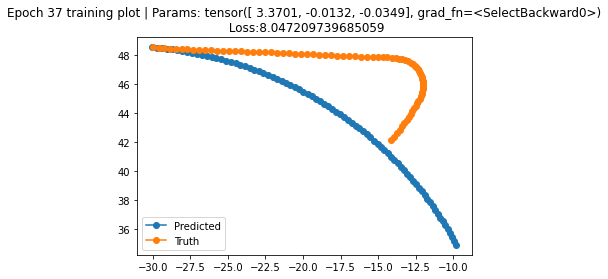

10.475569320739584


  0%|          | 0/118 [00:00<?, ?it/s]

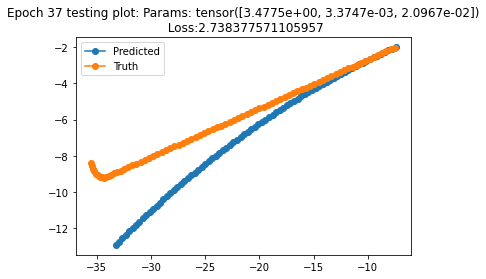

10.864314540968103
Epoch 37 | Train Loss: 10.475569320739584 | Test Loss: 10.864314540968103


  0%|          | 0/470 [00:00<?, ?it/s]

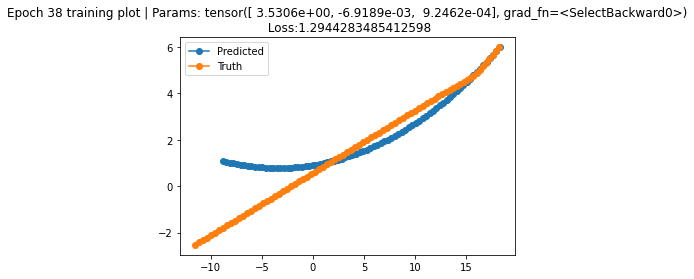

10.216150226998836


  0%|          | 0/118 [00:00<?, ?it/s]

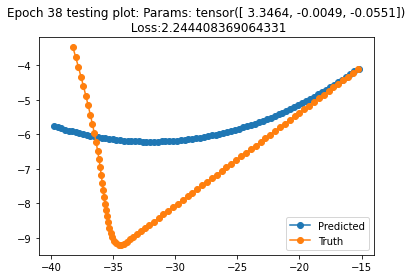

8.478810006531619
Epoch 38 | Train Loss: 10.216150226998836 | Test Loss: 8.478810006531619


  0%|          | 0/470 [00:00<?, ?it/s]

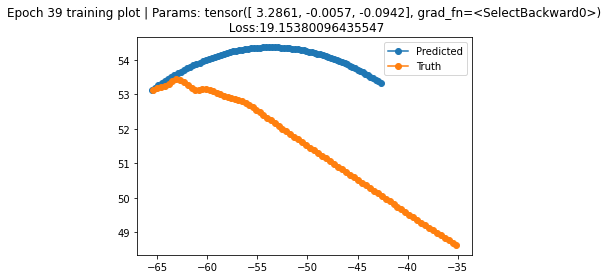

10.487938760950211


  0%|          | 0/118 [00:00<?, ?it/s]

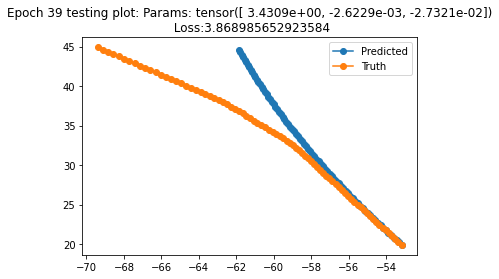

14.084111241971032
Epoch 39 | Train Loss: 10.487938760950211 | Test Loss: 14.084111241971032


  0%|          | 0/470 [00:00<?, ?it/s]

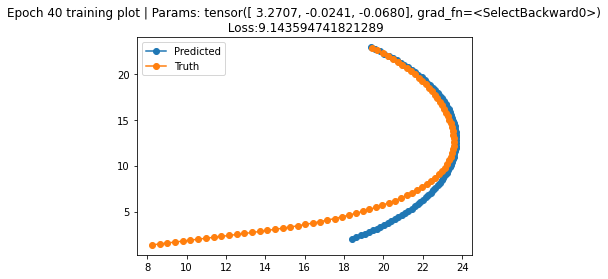

10.929312873774386


  0%|          | 0/118 [00:00<?, ?it/s]

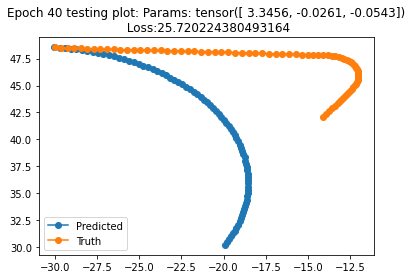

12.118799675319154
Epoch 40 | Train Loss: 10.929312873774386 | Test Loss: 12.118799675319154


  0%|          | 0/470 [00:00<?, ?it/s]

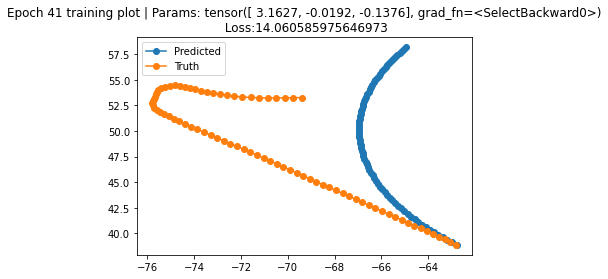

8.750520630973451


  0%|          | 0/118 [00:00<?, ?it/s]

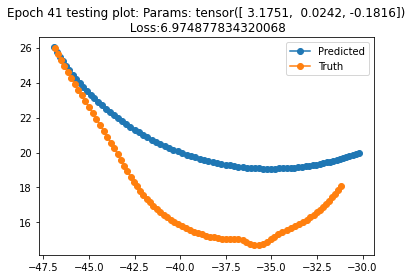

7.5197080262636735
Epoch 41 | Train Loss: 8.750520630973451 | Test Loss: 7.5197080262636735


  0%|          | 0/470 [00:00<?, ?it/s]

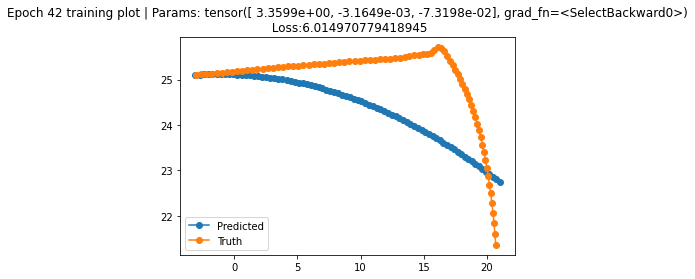

9.876677742093168


  0%|          | 0/118 [00:00<?, ?it/s]

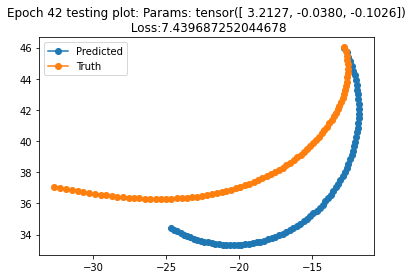

12.004297834331707
Epoch 42 | Train Loss: 9.876677742093168 | Test Loss: 12.004297834331707


  0%|          | 0/470 [00:00<?, ?it/s]

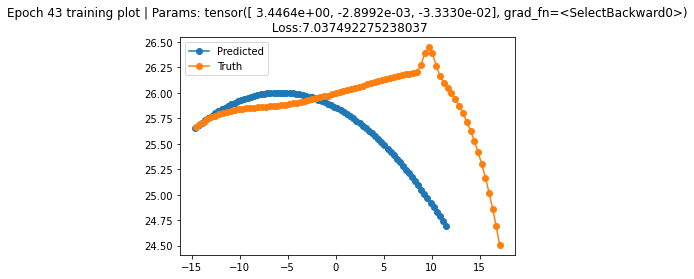

9.282962917330417


  0%|          | 0/118 [00:00<?, ?it/s]

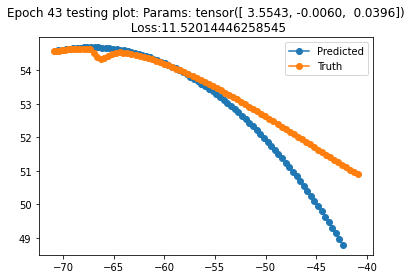

5.802374885243885
Epoch 43 | Train Loss: 9.282962917330417 | Test Loss: 5.802374885243885


  0%|          | 0/470 [00:00<?, ?it/s]

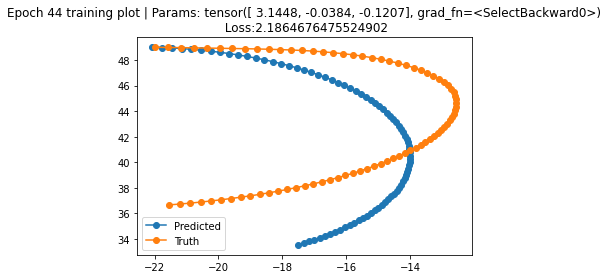

10.103379472424376


  0%|          | 0/118 [00:00<?, ?it/s]

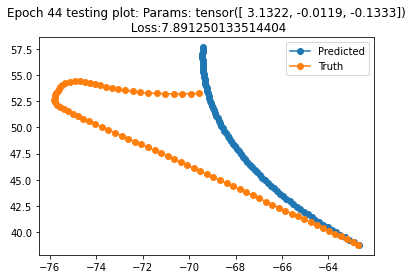

11.661337379176738
Epoch 44 | Train Loss: 10.103379472424376 | Test Loss: 11.661337379176738


  0%|          | 0/470 [00:00<?, ?it/s]

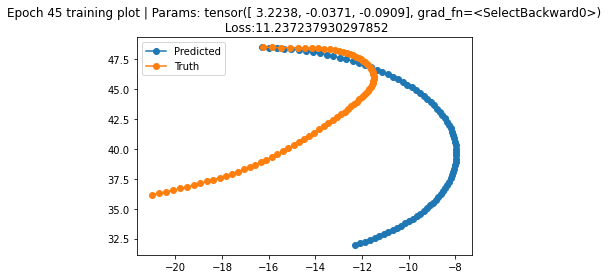

9.77875621648545


  0%|          | 0/118 [00:00<?, ?it/s]

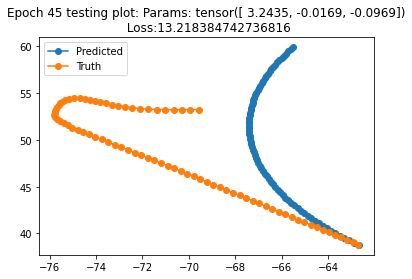

7.86345602294146
Epoch 45 | Train Loss: 9.77875621648545 | Test Loss: 7.86345602294146


  0%|          | 0/470 [00:00<?, ?it/s]

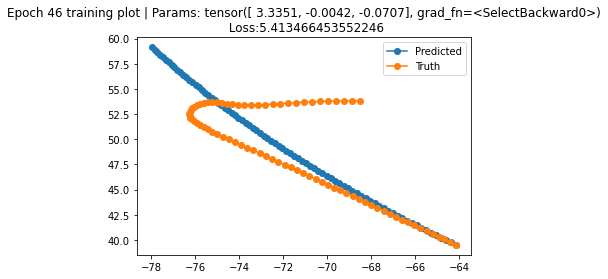

8.525199812270225


  0%|          | 0/118 [00:00<?, ?it/s]

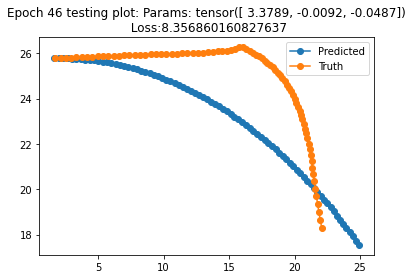

8.229964724031545
Epoch 46 | Train Loss: 8.525199812270225 | Test Loss: 8.229964724031545


  0%|          | 0/470 [00:00<?, ?it/s]

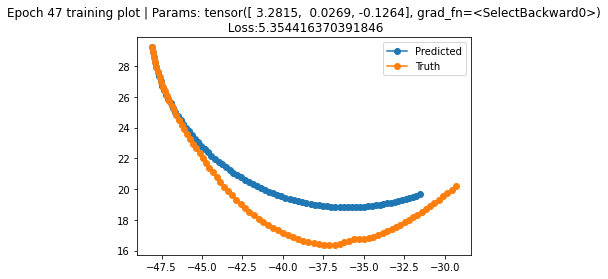

9.328543590516485


  0%|          | 0/118 [00:00<?, ?it/s]

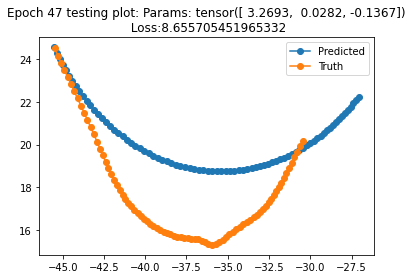

6.7978443192728495
Epoch 47 | Train Loss: 9.328543590516485 | Test Loss: 6.7978443192728495


  0%|          | 0/470 [00:00<?, ?it/s]

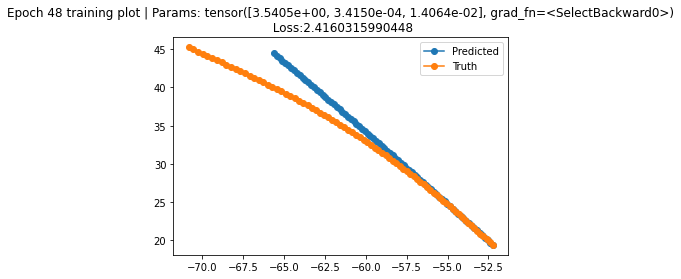

9.659090465053598


  0%|          | 0/118 [00:00<?, ?it/s]

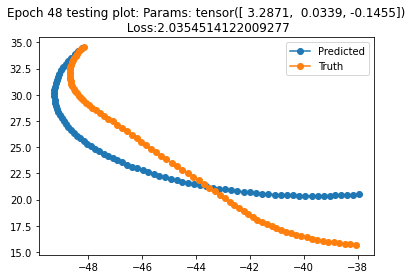

6.773776506468401
Epoch 48 | Train Loss: 9.659090465053598 | Test Loss: 6.773776506468401


  0%|          | 0/470 [00:00<?, ?it/s]

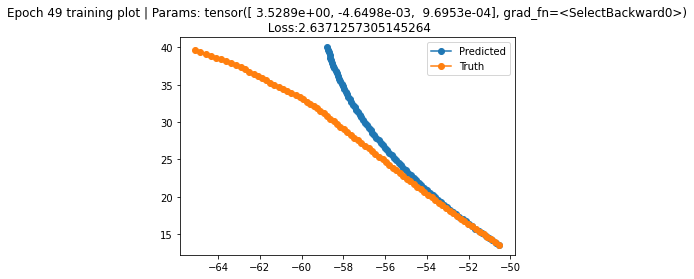

8.87103567018788


  0%|          | 0/118 [00:00<?, ?it/s]

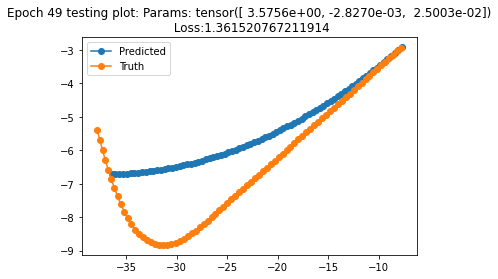

10.278006386453823
Epoch 49 | Train Loss: 8.87103567018788 | Test Loss: 10.278006386453823


  0%|          | 0/470 [00:00<?, ?it/s]

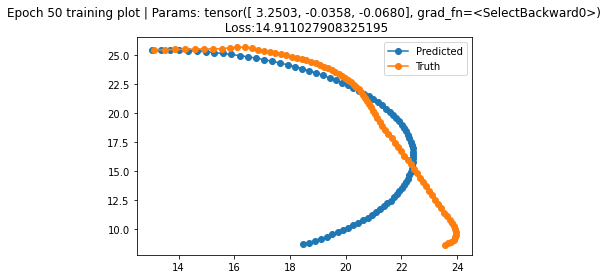

8.682401183184156


  0%|          | 0/118 [00:00<?, ?it/s]

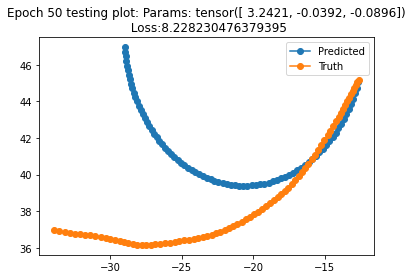

7.9745562985792
Epoch 50 | Train Loss: 8.682401183184156 | Test Loss: 7.9745562985792


  0%|          | 0/470 [00:00<?, ?it/s]

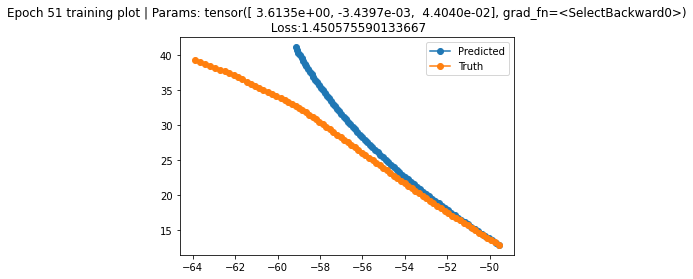

9.82641440788482


  0%|          | 0/118 [00:00<?, ?it/s]

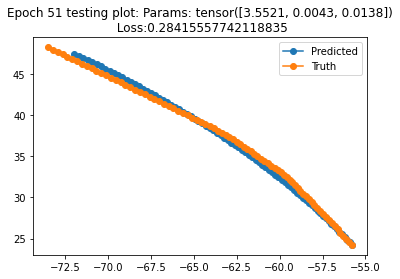

7.041690975175065
Epoch 51 | Train Loss: 9.82641440788482 | Test Loss: 7.041690975175065


  0%|          | 0/470 [00:00<?, ?it/s]

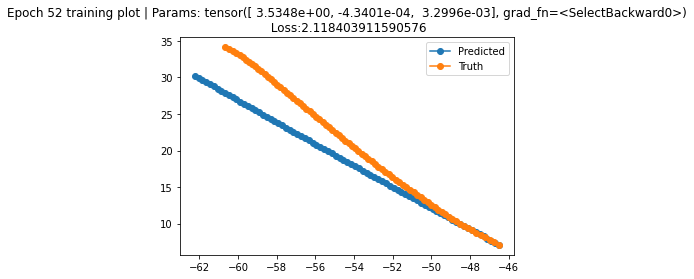

8.75040372153546


  0%|          | 0/118 [00:00<?, ?it/s]

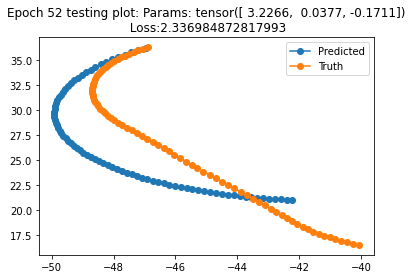

6.850329750170142
Epoch 52 | Train Loss: 8.75040372153546 | Test Loss: 6.850329750170142


  0%|          | 0/470 [00:00<?, ?it/s]

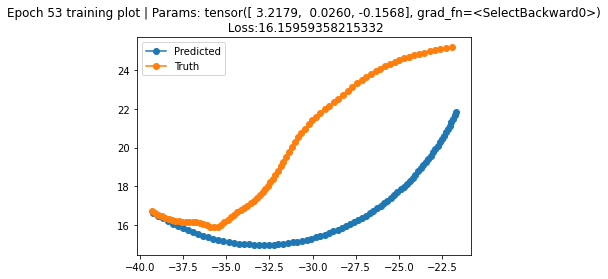

8.431323613194708


  0%|          | 0/118 [00:00<?, ?it/s]

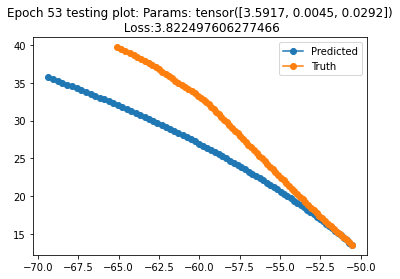

8.201785471479772
Epoch 53 | Train Loss: 8.431323613194708 | Test Loss: 8.201785471479772


  0%|          | 0/470 [00:00<?, ?it/s]

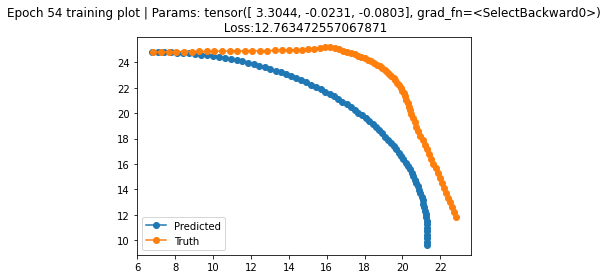

8.775248058409767


  0%|          | 0/118 [00:00<?, ?it/s]

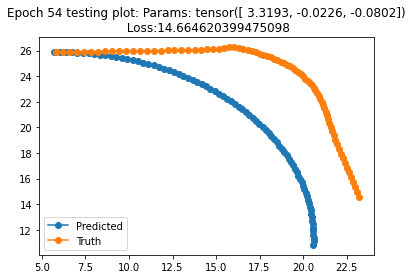

8.526243426031986
Epoch 54 | Train Loss: 8.775248058409767 | Test Loss: 8.526243426031986


  0%|          | 0/470 [00:00<?, ?it/s]

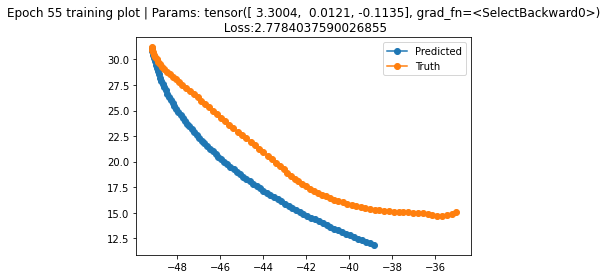

8.439196708639885


  0%|          | 0/118 [00:00<?, ?it/s]

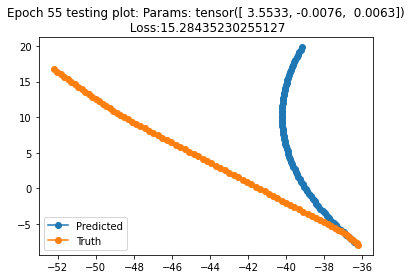

8.352321853577081
Epoch 55 | Train Loss: 8.439196708639885 | Test Loss: 8.352321853577081


  0%|          | 0/470 [00:00<?, ?it/s]

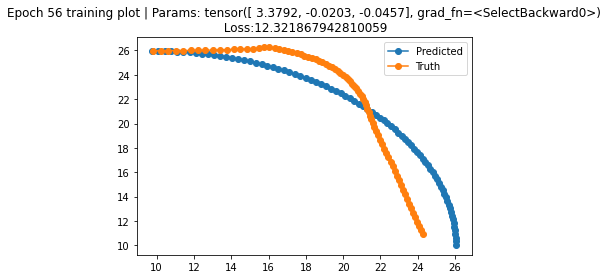

8.435364649841127


  0%|          | 0/118 [00:00<?, ?it/s]

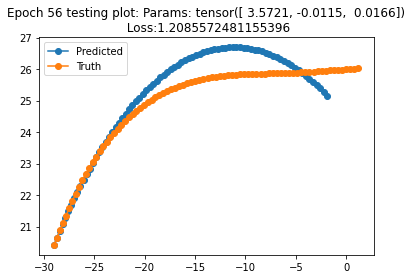

9.558068136289968
Epoch 56 | Train Loss: 8.435364649841127 | Test Loss: 9.558068136289968


  0%|          | 0/470 [00:00<?, ?it/s]

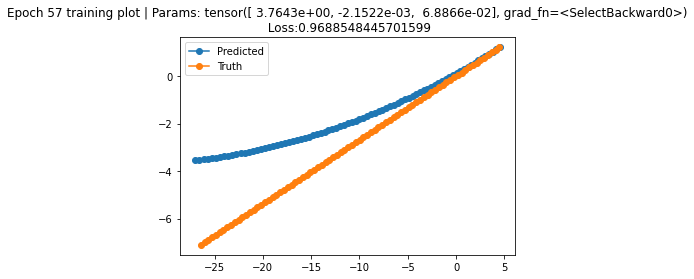

7.789944249851272


  0%|          | 0/118 [00:00<?, ?it/s]

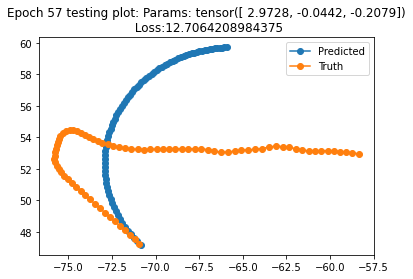

7.43888116185948
Epoch 57 | Train Loss: 7.789944249851272 | Test Loss: 7.43888116185948


  0%|          | 0/470 [00:00<?, ?it/s]

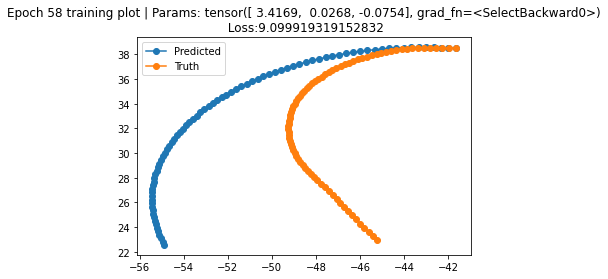

8.575171514140798


  0%|          | 0/118 [00:00<?, ?it/s]

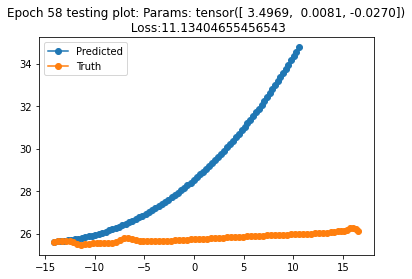

15.239157242290045
Epoch 58 | Train Loss: 8.575171514140798 | Test Loss: 15.239157242290045


  0%|          | 0/470 [00:00<?, ?it/s]

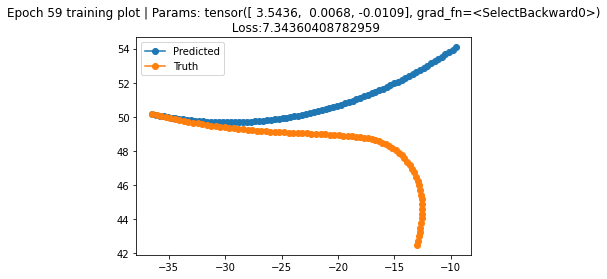

8.470560665460344


  0%|          | 0/118 [00:00<?, ?it/s]

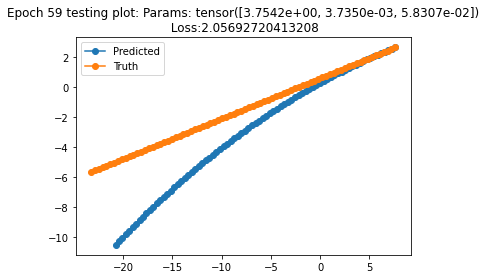

8.419368665223404
Epoch 59 | Train Loss: 8.470560665460344 | Test Loss: 8.419368665223404


  0%|          | 0/470 [00:00<?, ?it/s]

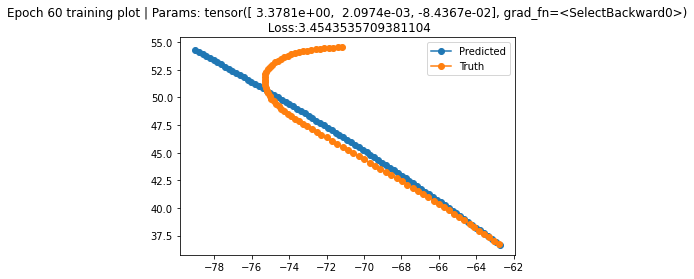

8.888041812561928


  0%|          | 0/118 [00:00<?, ?it/s]

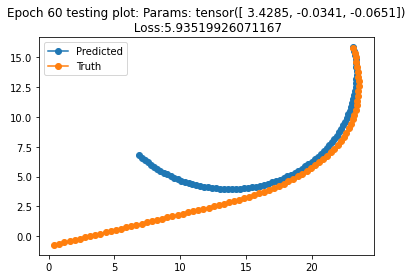

6.323557333420899
Epoch 60 | Train Loss: 8.888041812561928 | Test Loss: 6.323557333420899


  0%|          | 0/470 [00:00<?, ?it/s]

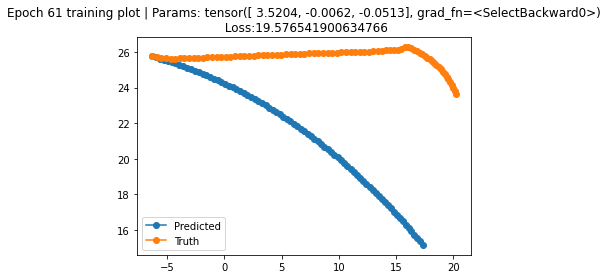

8.471445918178304


  0%|          | 0/118 [00:00<?, ?it/s]

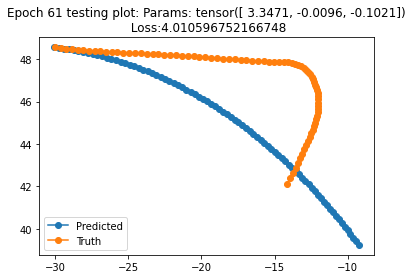

6.987415609218306
Epoch 61 | Train Loss: 8.471445918178304 | Test Loss: 6.987415609218306


  0%|          | 0/470 [00:00<?, ?it/s]

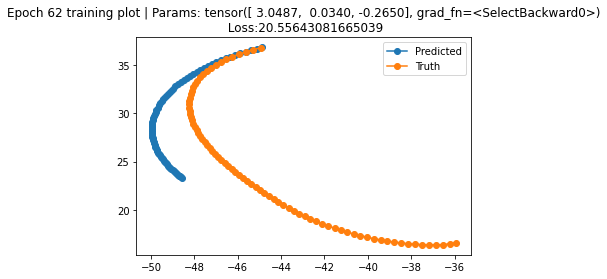

9.196690842889724


  0%|          | 0/118 [00:00<?, ?it/s]

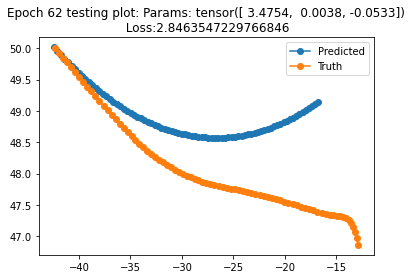

6.3152522717492054
Epoch 62 | Train Loss: 9.196690842889724 | Test Loss: 6.3152522717492054


  0%|          | 0/470 [00:00<?, ?it/s]

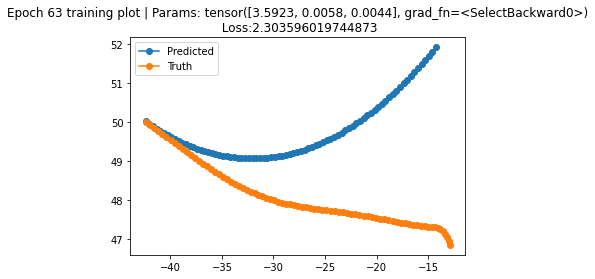

7.839839465789338


  0%|          | 0/118 [00:00<?, ?it/s]

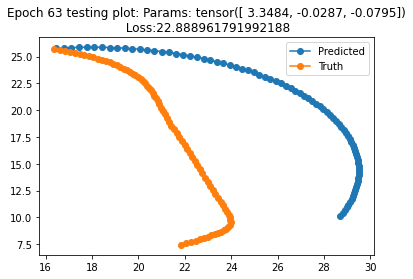

6.097079279753617
Epoch 63 | Train Loss: 7.839839465789338 | Test Loss: 6.097079279753617


  0%|          | 0/470 [00:00<?, ?it/s]

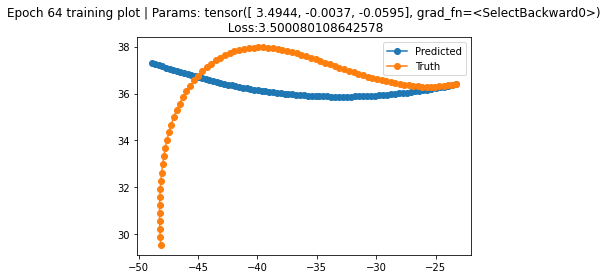

7.1942533085796425


  0%|          | 0/118 [00:00<?, ?it/s]

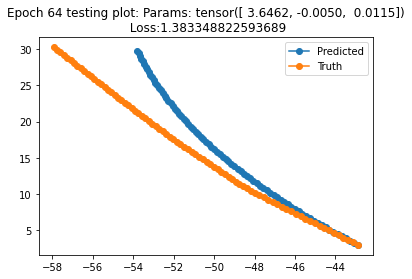

7.768925850169134
Epoch 64 | Train Loss: 7.1942533085796425 | Test Loss: 7.768925850169134


  0%|          | 0/470 [00:00<?, ?it/s]

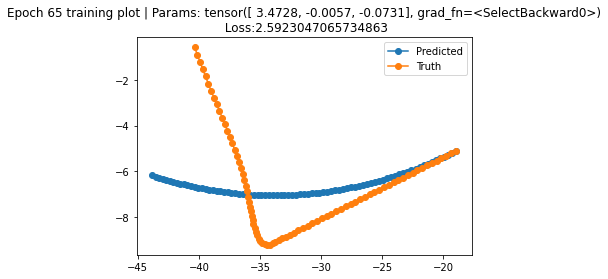

8.323927924132093


  0%|          | 0/118 [00:00<?, ?it/s]

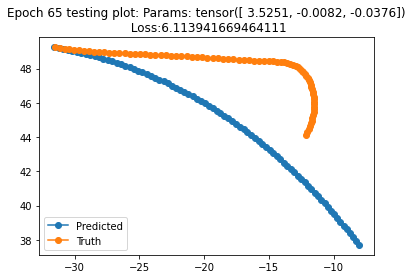

8.845328541630405
Epoch 65 | Train Loss: 8.323927924132093 | Test Loss: 8.845328541630405


  0%|          | 0/470 [00:00<?, ?it/s]

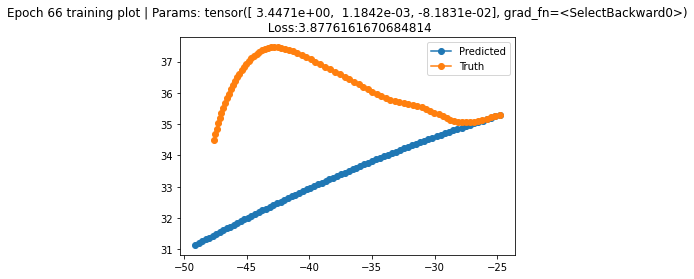

7.069680525505162


  0%|          | 0/118 [00:00<?, ?it/s]

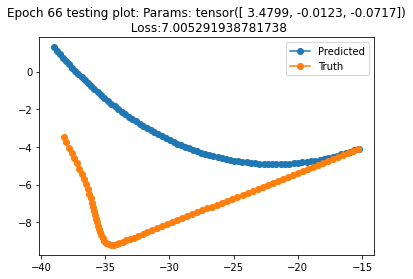

8.886950411028781
Epoch 66 | Train Loss: 7.069680525505162 | Test Loss: 8.886950411028781


  0%|          | 0/470 [00:00<?, ?it/s]

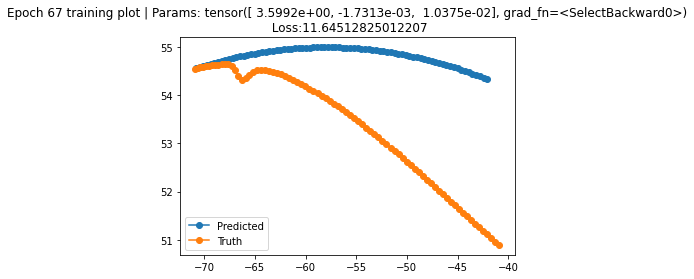

8.074011791323093


  0%|          | 0/118 [00:00<?, ?it/s]

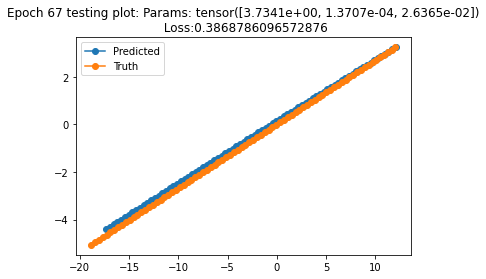

5.992962144946648
Epoch 67 | Train Loss: 8.074011791323093 | Test Loss: 5.992962144946648


  0%|          | 0/470 [00:00<?, ?it/s]

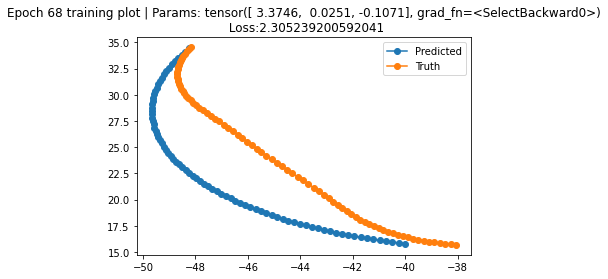

8.475599426379864


  0%|          | 0/118 [00:00<?, ?it/s]

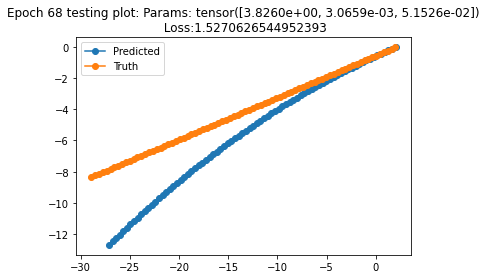

6.2677660182876105
Epoch 68 | Train Loss: 8.475599426379864 | Test Loss: 6.2677660182876105


  0%|          | 0/470 [00:00<?, ?it/s]

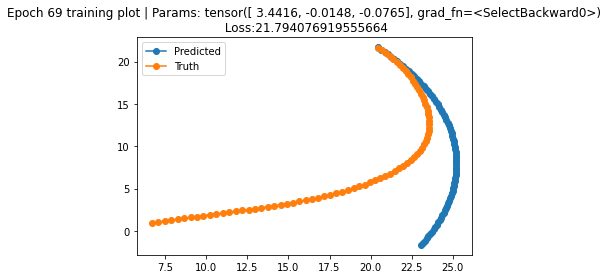

7.9194718488828935


  0%|          | 0/118 [00:00<?, ?it/s]

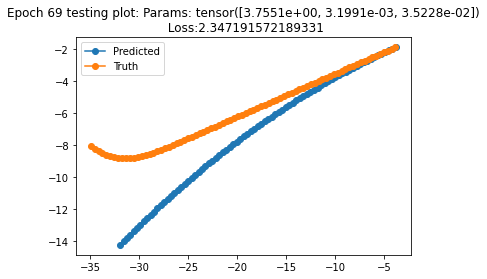

5.993938501482293
Epoch 69 | Train Loss: 7.9194718488828935 | Test Loss: 5.993938501482293


  0%|          | 0/470 [00:00<?, ?it/s]

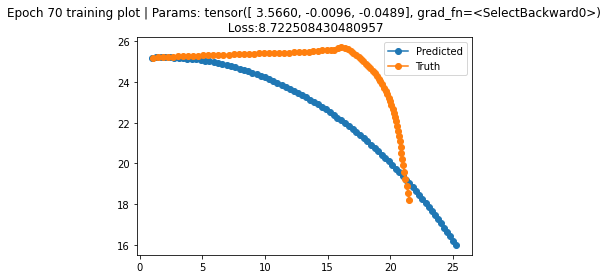

7.462248105539921


  0%|          | 0/118 [00:00<?, ?it/s]

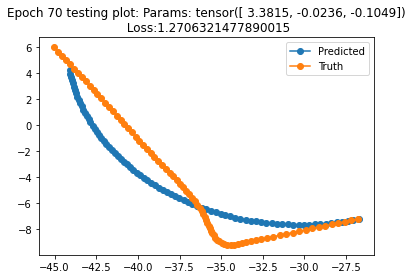

5.761198927032745
Epoch 70 | Train Loss: 7.462248105539921 | Test Loss: 5.761198927032745


  0%|          | 0/470 [00:00<?, ?it/s]

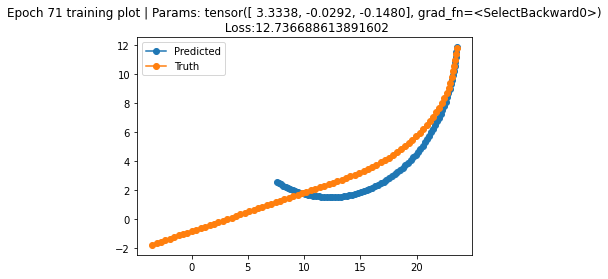

7.976426525374359


  0%|          | 0/118 [00:00<?, ?it/s]

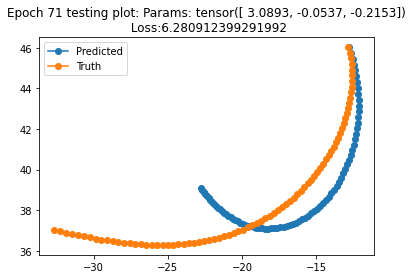

7.43893560666149
Epoch 71 | Train Loss: 7.976426525374359 | Test Loss: 7.43893560666149


  0%|          | 0/470 [00:00<?, ?it/s]

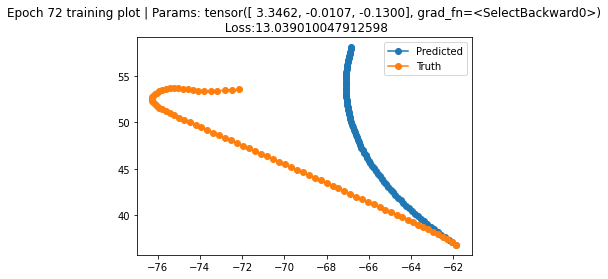

8.050597853419628


  0%|          | 0/118 [00:00<?, ?it/s]

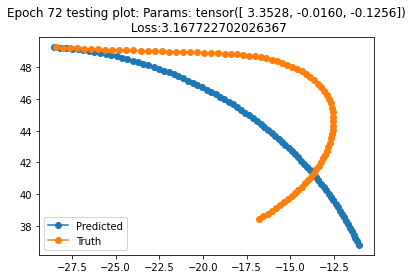

8.75043435268483
Epoch 72 | Train Loss: 8.050597853419628 | Test Loss: 8.75043435268483


  0%|          | 0/470 [00:00<?, ?it/s]

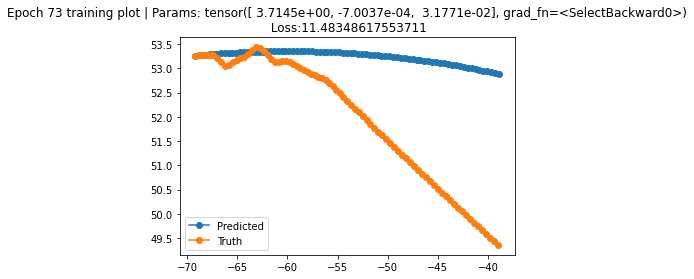

7.006437478579105


  0%|          | 0/118 [00:00<?, ?it/s]

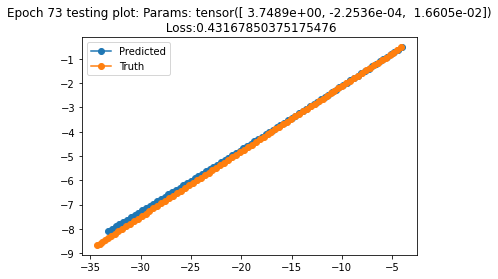

6.339846472303241
Epoch 73 | Train Loss: 7.006437478579105 | Test Loss: 6.339846472303241


  0%|          | 0/470 [00:00<?, ?it/s]

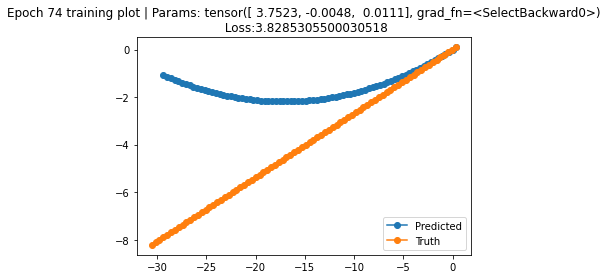

7.250791393109458


  0%|          | 0/118 [00:00<?, ?it/s]

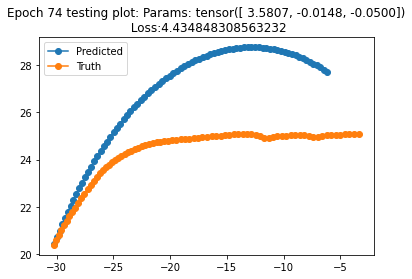

7.018084314162448
Epoch 74 | Train Loss: 7.250791393109458 | Test Loss: 7.018084314162448


  0%|          | 0/470 [00:00<?, ?it/s]

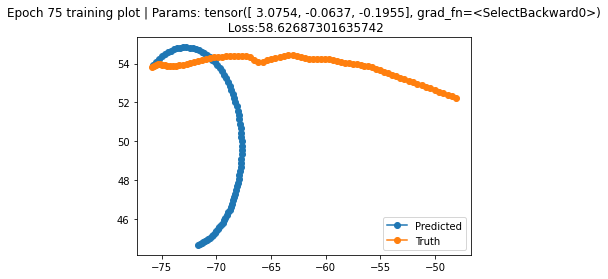

7.5820912746672935


  0%|          | 0/118 [00:00<?, ?it/s]

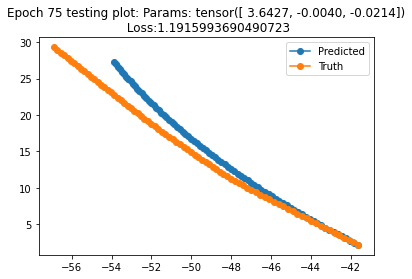

7.059024373858662
Epoch 75 | Train Loss: 7.5820912746672935 | Test Loss: 7.059024373858662


  0%|          | 0/470 [00:00<?, ?it/s]

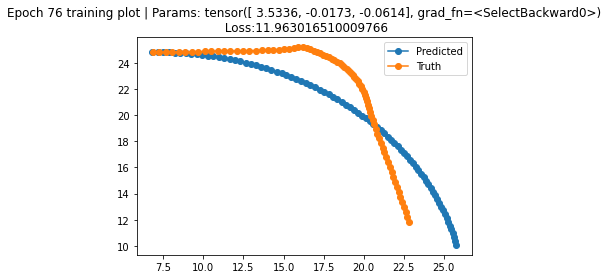

7.188562591801933


  0%|          | 0/118 [00:00<?, ?it/s]

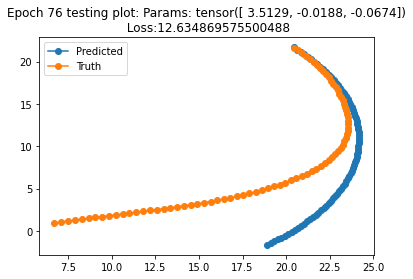

8.331745183063767
Epoch 76 | Train Loss: 7.188562591801933 | Test Loss: 8.331745183063767


  0%|          | 0/470 [00:00<?, ?it/s]

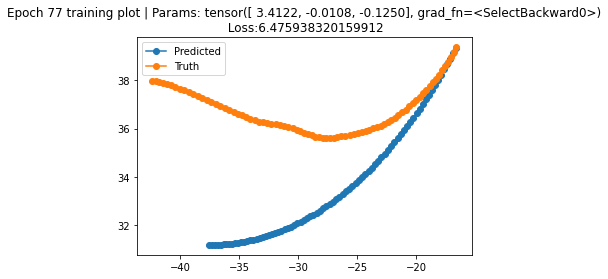

8.987394383977703


  0%|          | 0/118 [00:00<?, ?it/s]

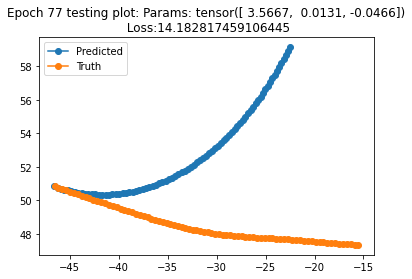

17.192277158215894
Epoch 77 | Train Loss: 8.987394383977703 | Test Loss: 17.192277158215894


  0%|          | 0/470 [00:00<?, ?it/s]

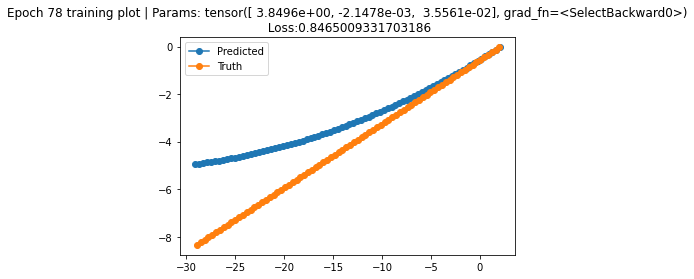

6.941903246400204


  0%|          | 0/118 [00:00<?, ?it/s]

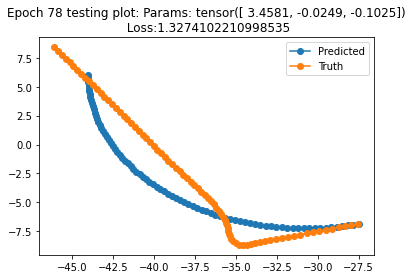

5.555033413914301
Epoch 78 | Train Loss: 6.941903246400204 | Test Loss: 5.555033413914301


  0%|          | 0/470 [00:00<?, ?it/s]

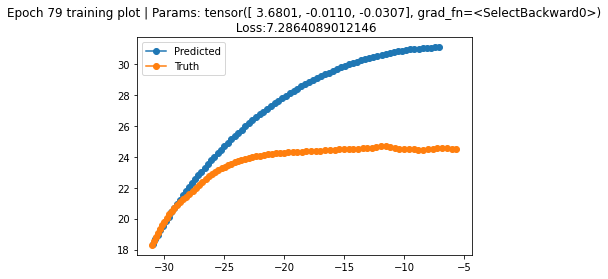

7.425363309824086


  0%|          | 0/118 [00:00<?, ?it/s]

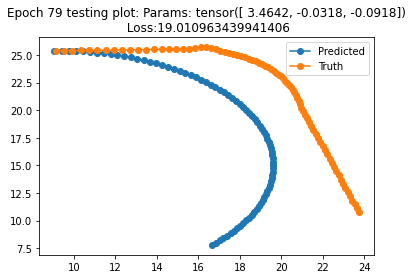

5.988872335308184
Epoch 79 | Train Loss: 7.425363309824086 | Test Loss: 5.988872335308184


  0%|          | 0/470 [00:00<?, ?it/s]

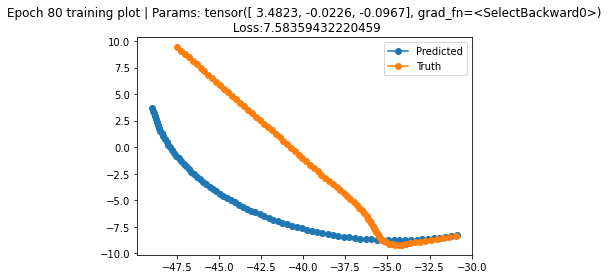

7.433262957458166


  0%|          | 0/118 [00:00<?, ?it/s]

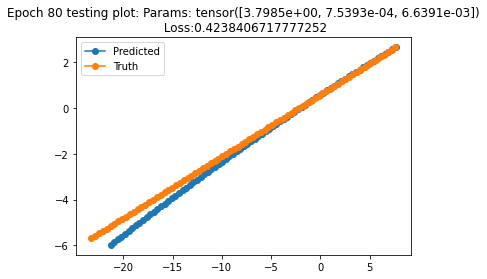

5.476744483335543
Epoch 80 | Train Loss: 7.433262957458166 | Test Loss: 5.476744483335543


  0%|          | 0/470 [00:00<?, ?it/s]

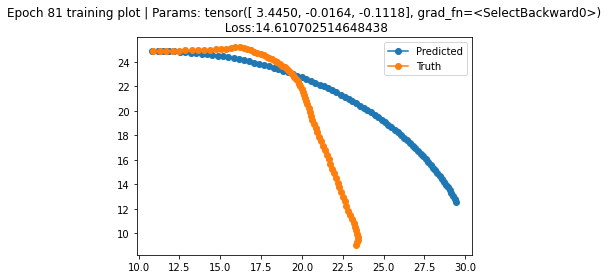

7.211899331370566


  0%|          | 0/118 [00:00<?, ?it/s]

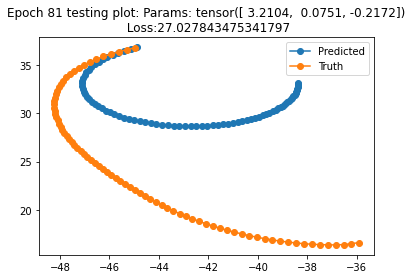

15.153830270140858
Epoch 81 | Train Loss: 7.211899331370566 | Test Loss: 15.153830270140858


  0%|          | 0/470 [00:00<?, ?it/s]

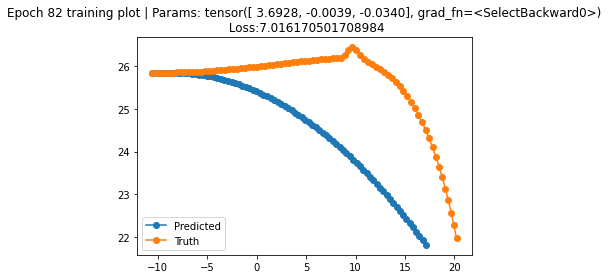

7.46004300878403


  0%|          | 0/118 [00:00<?, ?it/s]

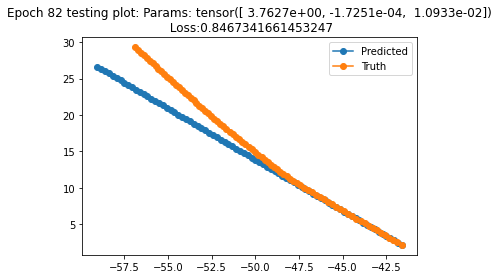

5.847677650971938
Epoch 82 | Train Loss: 7.46004300878403 | Test Loss: 5.847677650971938


  0%|          | 0/470 [00:00<?, ?it/s]

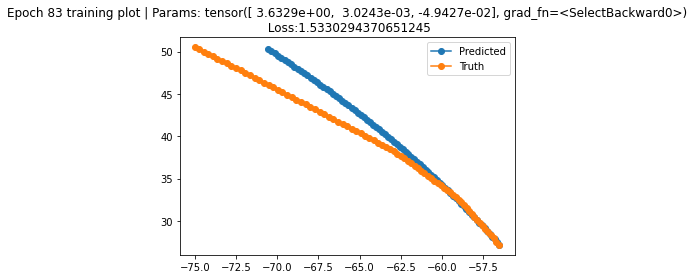

7.380184983224311


  0%|          | 0/118 [00:00<?, ?it/s]

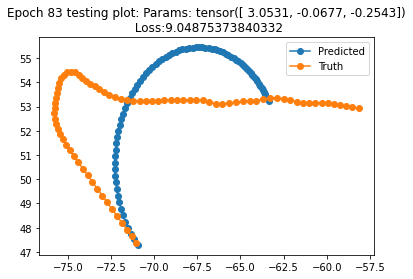

6.058967593994181
Epoch 83 | Train Loss: 7.380184983224311 | Test Loss: 6.058967593994181


  0%|          | 0/470 [00:00<?, ?it/s]

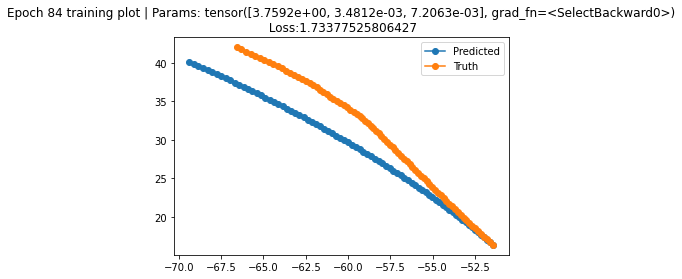

7.443726618191663


  0%|          | 0/118 [00:00<?, ?it/s]

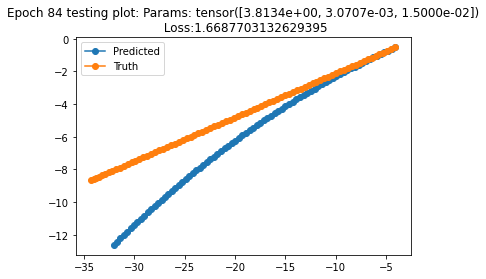

5.7980646852845865
Epoch 84 | Train Loss: 7.443726618191663 | Test Loss: 5.7980646852845865


  0%|          | 0/470 [00:00<?, ?it/s]

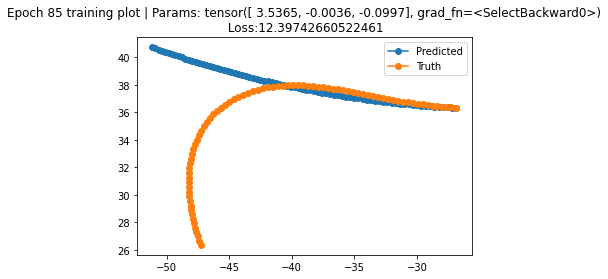

7.246184830351713


  0%|          | 0/118 [00:00<?, ?it/s]

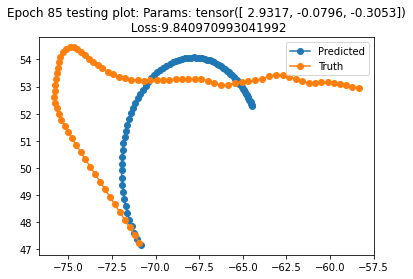

6.87350952903093
Epoch 85 | Train Loss: 7.246184830351713 | Test Loss: 6.87350952903093


  0%|          | 0/470 [00:00<?, ?it/s]

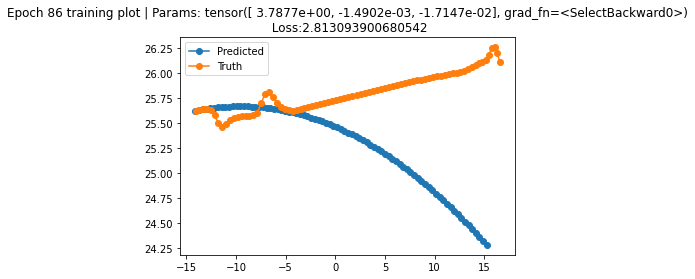

7.5603033242073465


  0%|          | 0/118 [00:00<?, ?it/s]

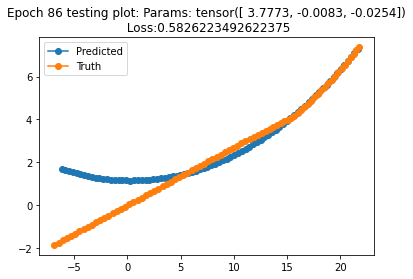

5.393235385986203
Epoch 86 | Train Loss: 7.5603033242073465 | Test Loss: 5.393235385986203


  0%|          | 0/470 [00:00<?, ?it/s]

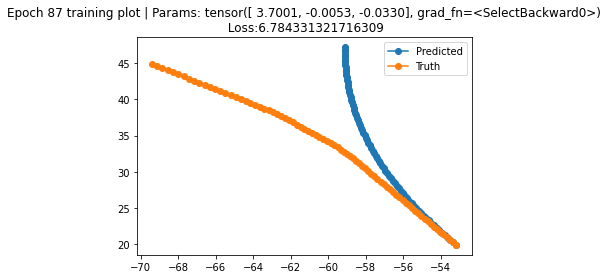

7.518293426558375


  0%|          | 0/118 [00:00<?, ?it/s]

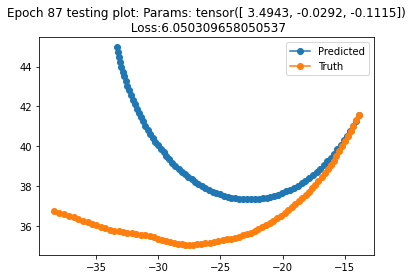

8.531429242027007
Epoch 87 | Train Loss: 7.518293426558375 | Test Loss: 8.531429242027007


  0%|          | 0/470 [00:00<?, ?it/s]

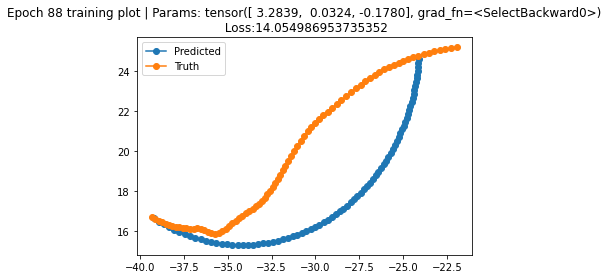

7.412414790531423


  0%|          | 0/118 [00:00<?, ?it/s]

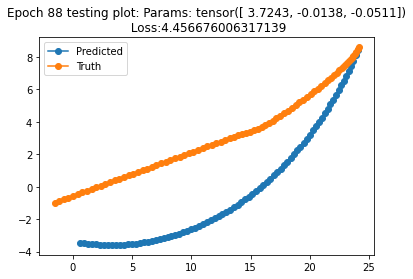

8.071294690466534
Epoch 88 | Train Loss: 7.412414790531423 | Test Loss: 8.071294690466534


  0%|          | 0/470 [00:00<?, ?it/s]

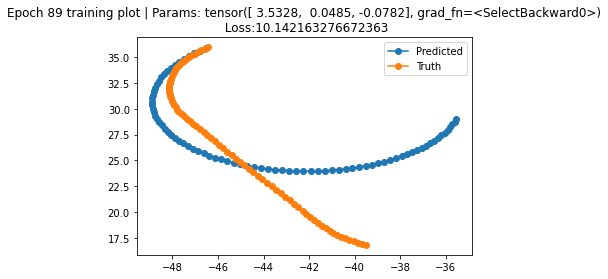

6.979932168102327


  0%|          | 0/118 [00:00<?, ?it/s]

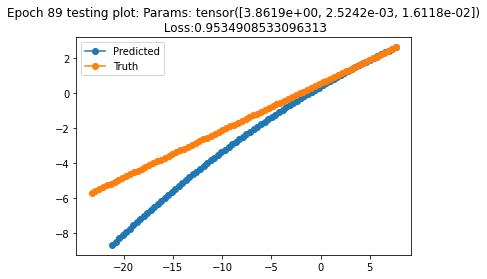

6.163724761140549
Epoch 89 | Train Loss: 6.979932168102327 | Test Loss: 6.163724761140549


  0%|          | 0/470 [00:00<?, ?it/s]

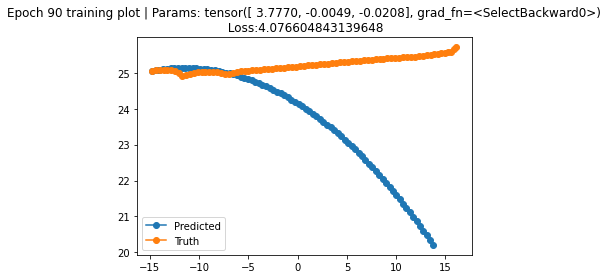

7.518989298175624


  0%|          | 0/118 [00:00<?, ?it/s]

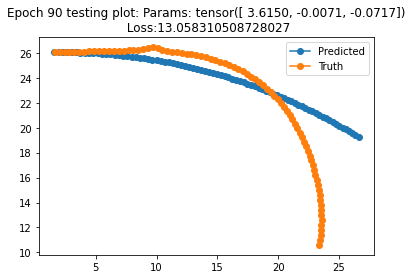

5.616503553370298
Epoch 90 | Train Loss: 7.518989298175624 | Test Loss: 5.616503553370298


  0%|          | 0/470 [00:00<?, ?it/s]

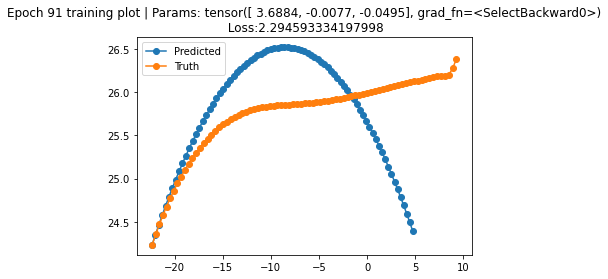

8.15357474393033


  0%|          | 0/118 [00:00<?, ?it/s]

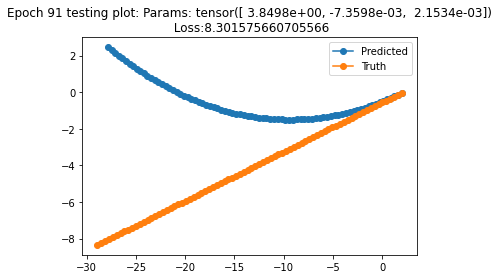

9.022885505425728
Epoch 91 | Train Loss: 8.15357474393033 | Test Loss: 9.022885505425728


  0%|          | 0/470 [00:00<?, ?it/s]

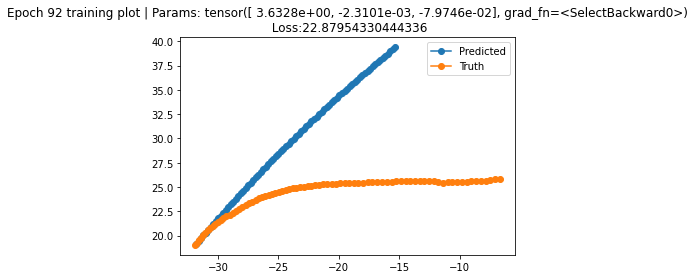

6.459100266672829


  0%|          | 0/118 [00:00<?, ?it/s]

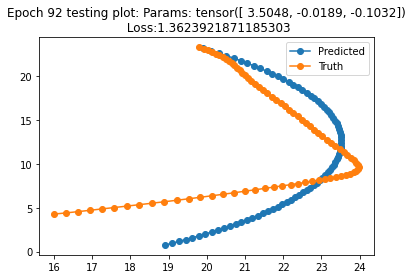

6.856685606036651
Epoch 92 | Train Loss: 6.459100266672829 | Test Loss: 6.856685606036651


  0%|          | 0/470 [00:00<?, ?it/s]

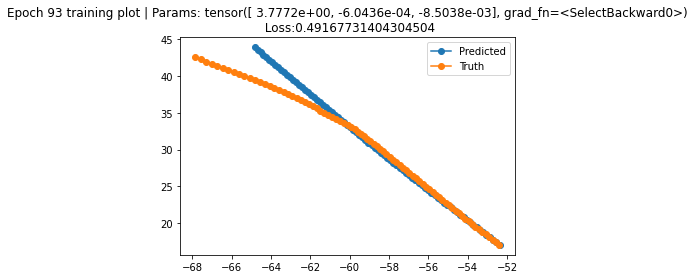

6.901802006554096


  0%|          | 0/118 [00:00<?, ?it/s]

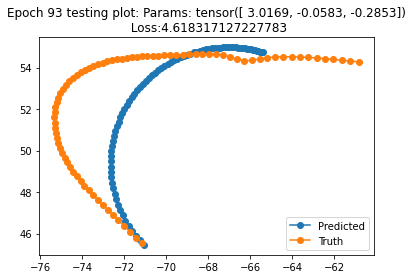

5.313385965334157
Epoch 93 | Train Loss: 6.901802006554096 | Test Loss: 5.313385965334157


  0%|          | 0/470 [00:00<?, ?it/s]

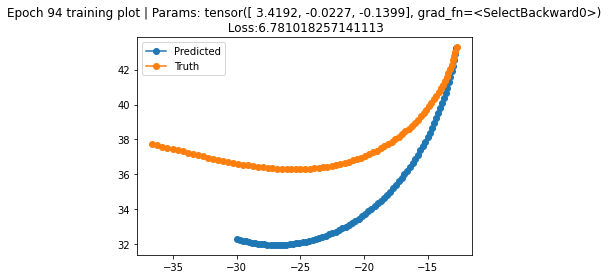

6.506028005607584


  0%|          | 0/118 [00:00<?, ?it/s]

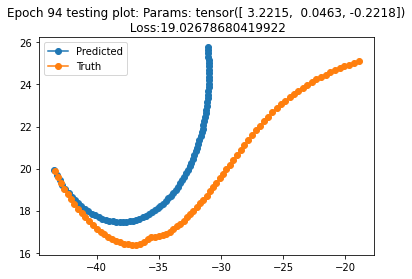

11.322740306793634
Epoch 94 | Train Loss: 6.506028005607584 | Test Loss: 11.322740306793634


  0%|          | 0/470 [00:00<?, ?it/s]

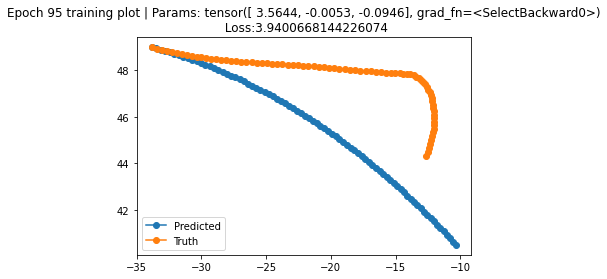

7.648428589612879


  0%|          | 0/118 [00:00<?, ?it/s]

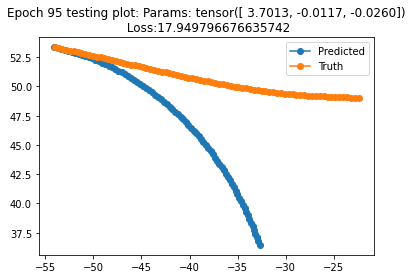

10.980648287272048
Epoch 95 | Train Loss: 7.648428589612879 | Test Loss: 10.980648287272048


  0%|          | 0/470 [00:00<?, ?it/s]

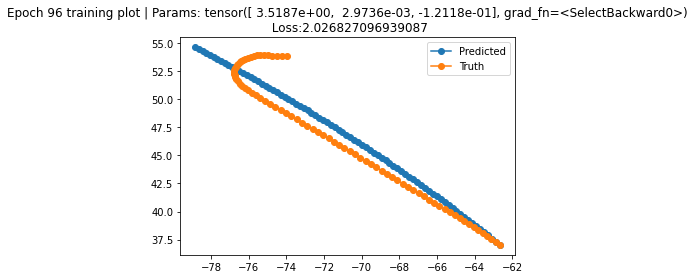

7.662709142077476


  0%|          | 0/118 [00:00<?, ?it/s]

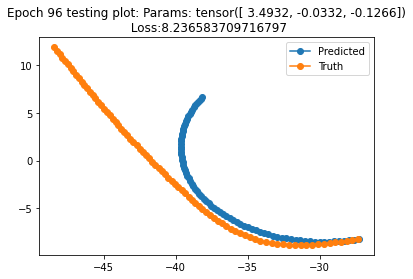

8.964476739956162
Epoch 96 | Train Loss: 7.662709142077476 | Test Loss: 8.964476739956162


  0%|          | 0/470 [00:00<?, ?it/s]

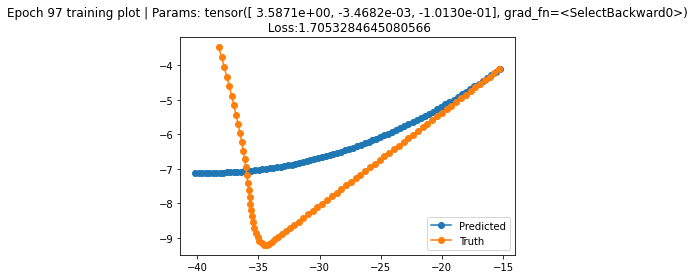

7.408832040540082


  0%|          | 0/118 [00:00<?, ?it/s]

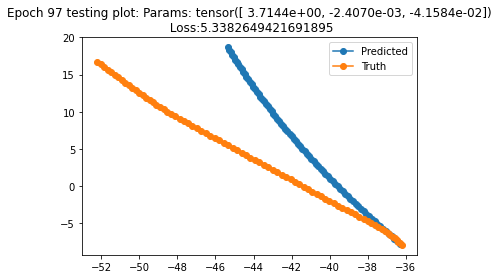

6.098178997162288
Epoch 97 | Train Loss: 7.408832040540082 | Test Loss: 6.098178997162288


  0%|          | 0/470 [00:00<?, ?it/s]

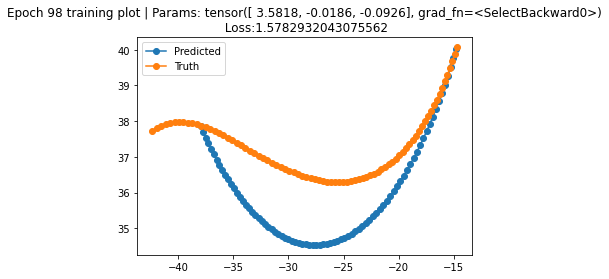

7.458138599785719


  0%|          | 0/118 [00:00<?, ?it/s]

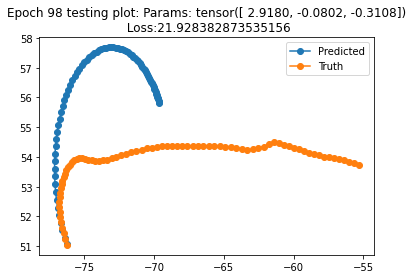

5.163862785924289
Epoch 98 | Train Loss: 7.458138599785719 | Test Loss: 5.163862785924289


  0%|          | 0/470 [00:00<?, ?it/s]

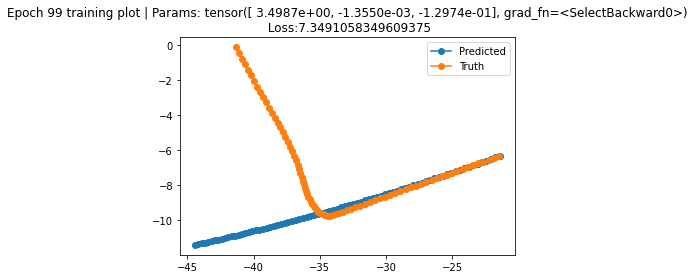

6.580421458517617


  0%|          | 0/118 [00:00<?, ?it/s]

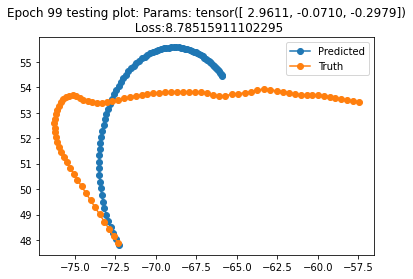

18.001119034775233
Epoch 99 | Train Loss: 6.580421458517617 | Test Loss: 18.001119034775233


In [15]:
# Training Loop
torch.autograd.set_detect_anomaly(True)
net = LSTMPredictor()
net.to(DEVICE)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
train_losses = list()
test_losses = list()
BATCH_SIZE = 32

for epoch in range(100):
    cum_train_loss = 0.0
    net.train()
    i=0
    for input_data, target_data in tqdm(train_dataloader):
        if i%BATCH_SIZE == 0:
            net.zero_grad()
        input_data = input_data.squeeze().to(DEVICE)
        outp = net(input_data)
        outp = outp.squeeze()
        outp = outp.to("cpu")
        target_data = target_data.squeeze()
        #print(outp.shape)
        outp_trace = bicycle_model_eval(outp[-1], input_data[-1].detach().clone().to("cpu")).to(DEVICE)
        loss = custom_loss_func(outp_trace, target_data.squeeze().to(DEVICE), outp[-1])
        loss.backward()
        if i%BATCH_SIZE == 0:
            optimizer.step()
        cum_train_loss += loss.item()
    # Catch remainder gradients
    optimizer.step()
    net.zero_grad()
    
    plt.title(f"Epoch {epoch} training plot | Params: {outp[-1]}\n Loss:{loss.item()}")
    plt.plot(outp_trace[:,0].detach().cpu().numpy(), outp_trace[:,1].detach().cpu().numpy(), marker='o', label="Predicted")
    plt.plot(target_data[:,0].detach().cpu().numpy(), target_data[:,1].detach().cpu().numpy(), marker='o', label="Truth")
    plt.legend()
    plt.show()
    cum_train_loss /= len(train_dataset)
    train_losses.append(cum_train_loss)
    print(cum_train_loss)
    cum_test_loss = 0.0
    net.eval()
    with torch.no_grad():
        for input_data, target_data in tqdm(test_dataloader):
            input_data = input_data.squeeze().to(DEVICE)
            outp = net(input_data)
            outp = outp.squeeze()
            outp = outp.to("cpu")
            target_data = target_data.squeeze()
            outp_trace = bicycle_model_eval(outp[-1], input_data[-1].detach().clone().to("cpu")).to(DEVICE)
            loss = custom_loss_func(outp_trace, target_data.squeeze().to(DEVICE), outp[-1])
            cum_test_loss += loss.item()
        plt.title(f"Epoch {epoch} testing plot: Params: {outp[-1]}\n Loss:{loss.item()}")
        plt.plot(outp_trace[:,0].detach().cpu().numpy(), outp_trace[:,1].detach().cpu().numpy(), marker='o', label="Predicted")
        plt.plot(target_data[:,0].detach().cpu().numpy(), target_data[:,1].detach().cpu().numpy(), marker='o', label="Truth")
        plt.legend()
        plt.show()
    cum_test_loss /= len(test_dataset)
    test_losses.append(cum_test_loss)
    if cum_test_loss <= min(test_losses):
        torch.save(net.state_dict(), "best_simple_bicycle.pt")
    print(cum_test_loss)
    print(f"Epoch {epoch} | Train Loss: {cum_train_loss} | Test Loss: {cum_test_loss}")

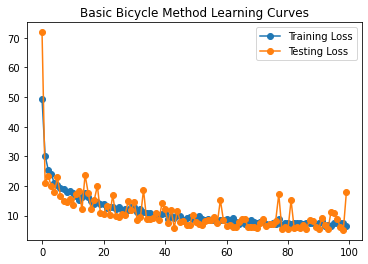

In [17]:
plt.title(f"Basic Bicycle Method Learning Curves")
plt.plot(train_losses, marker='o', label="Training Loss")
plt.plot(test_losses, marker='o', label="Testing Loss")
plt.legend()
plt.savefig("basic_learning.png")

In [ ]:
test_losses

In [18]:
pytorch_total_params = sum(p.numel() for p in net.parameters())
pytorch_total_params

1623